# setup and imports

In [136]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [137]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    histologyroot="/home/david/Desktop/HISTOLOGY"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to histology is: %s"%histologyroot)
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(histologyroot+"/*"))} rats in the histology folder')
print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')


Path to histology is: /home/david/Desktop/HISTOLOGY
Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 13 rats in the histology folder
Found 34 rats in the data folder


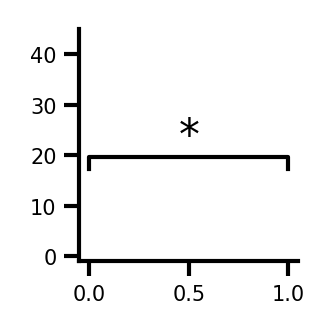

In [138]:
def barplot_annotate_brackets(ax, num1, num2, data, center, height, dh=.05, barh=.05, fs=None, maxasterix=3):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    ax_y0, ax_y1 = ax.get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    ax.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs)

fig, ax = plt.subplots(1, 1, figsize=(1, 1))

ax.set_ylim(-1, 45)
barplot_annotate_brackets(ax, 0, 1, 0.005, [0, 1, 0], [10, 15, 0], maxasterix=3)

In [139]:
rat_markers = {}
sequence = {}
XtrackRunToLeftBin, XtrackRunToRightBin = {}, {}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
            #    'RatF20': 'thcre', 'RatF21': 'thcre', 'RatF22': 'thcre',
            #    'RatM20': 'thcre', 'RatM21': 'thcre', 'RatM22': 'thcre',
               'RatF30': 'DLS', 'RatF31': 'DLS', 'RatF32': 'normal', 'RatF33': 'normal',
               'RatM30': 'DLS', 'RatM31': 'normal', 'RatM32': 'normal',
               'RatF40': 'DLS', 'RatF41': 'DMS', 'RatF42': 'normal',
               'RatM40': 'normal', 'RatM41': 'DLS', 'RatM42': 'DMS', 'RatM43': 'normal', 

                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'
               }

intact_map = plt.cm.get_cmap('winter')
lesion_map = plt.cm.get_cmap('autumn')

# markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
# lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

markers = {'normal': 'o', 'DLS': 'X', 'DMS': 'x'}
lines = {'normal': '-', 'DLS': '-', 'DMS': '-'}
colormaps = {'normal': intact_map, 'DLS': lesion_map, 'DMS': lesion_map}


animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

lesioned = ['RatF30', 'RatF31', 'RatM30', 'RatF40', 'RatF41', 'RatM41', 'RatM42',
            'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52']

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[colormaps[brainstatus[animal]](index/len(animalList)), 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    if animal == 'RatF02':
        rat_markers[animal][0] = 'k'

    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        # get the preprocessed data from the pickle file
        # biglesion = True if 'L' in session else False/
        
        # params[animal, session]     = get_from_pickle(root, animal, session, name="params.p")
        # sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)
        XtrackRunToLeftBin[animal, session], XtrackRunToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackPos.p")
        # trackTimeToLeftBin[animal, session], trackTimeToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackTime.p")
        # instantSpeedLeftBin[animal, session],instantSpeedRightBin[animal, session]= get_from_pickle(root, animal, session, name="trackSpeed.p")      

        
 


epsilon_0, epsilon_t, epsilon_R, power = pickle.load(open('picklejar/effort_fit.p', 'rb'))

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF30
Loading data for RatF31
Loading data for RatF32
Loading data for RatF33
Loading data for RatM30
Loading data for RatM31
Loading data for RatM32
Loading data for RatF40
Loading data for RatF41
Loading data for RatF42
Loading data for RatM40
Loading data for RatM41
Loading data for RatM42
Loading data for RatM43
Loading data for RatF50
Loading data for RatF51
Loading data for RatF52
Loading data for RatM50
Loading data for RatM51
Loading data for RatM52
Loading data for RatM53
Loading data for RatM54


In [140]:
import csv

def read_ROI_from_csv(file_path):
    ROI = []
    try:
        with open(file_path, mode='r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                if len(row) == 2:
                    try:
                        x = round(float(row[0]))
                        y = round(float(row[1]))
                        ROI.append((x, y))
                    except ValueError:
                        if row[0] == 'X' and row[1] == 'Y':
                            continue
                        else:
                            print(f"Skipping invalid row: {row}")
                else:
                    print(f"Skipping row with incorrect number of columns: {row}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred while reading the file: {str(e)}")

    return np.array(ROI)

def compute_area(ROI):
    '''Compute the area of a polygonal ROI using the shoelace formula'''
    n = len(ROI)
    area = 0.0

    for i in range(n):
        x1, y1 = ROI[i]
        x2, y2 = ROI[(i + 1) % n]
        area += (x1 * y2 - x2 * y1)

    area = abs(area) / 2.0
    return area

def compute_centroid(ROI):
    '''Compute the centroid of a polygonal ROI using the shoelace formula'''
    n = len(ROI)
    if n == 0:
        return None

    sum_x = 0
    sum_y = 0
    signed_area = 0

    for i in range(n):
        x1, y1 = ROI[i]
        x2, y2 = ROI[(i + 1) % n]  # Wrap around for the last point

        cross_product = (x1 * y2 - x2 * y1)
        signed_area += cross_product
        sum_x += (x1 + x2) * cross_product
        sum_y += (y1 + y2) * cross_product

    signed_area /= 2.0
    centroid_x = sum_x / (6 * signed_area)
    centroid_y = sum_y / (6 * signed_area)

    return (centroid_x, centroid_y)

lesion_area = {animal: [] for animal in lesioned}
shifts = {animal: [] for animal in lesioned}
for animal in lesioned:
    print(animal)
    animalFolder = histologyroot + '/' + animal
    slices = glob.glob(animalFolder + '/slice*.czi')
    for slice in slices:
        print(slice)
        ROI_Left_Striatum = read_ROI_from_csv(slice[:-4] + '_Left_Striatum.csv')
        ROI_Right_Striatum = read_ROI_from_csv(slice[:-4] + '_Right_Striatum.csv')
        ROI_Left_Lesion = read_ROI_from_csv(slice[:-4] + '_Left_Lesion.csv')
        ROI_Right_Lesion = read_ROI_from_csv(slice[:-4] + '_Right_Lesion.csv')


        AREA_Left_Striatum = compute_area(ROI_Left_Striatum)
        AREA_Right_Striatum = compute_area(ROI_Right_Striatum)
        AREA_Left_Lesion = compute_area(ROI_Left_Lesion)
        AREA_Right_Lesion = compute_area(ROI_Right_Lesion)

        CENTROID_Left_Striatum, _ = compute_centroid(ROI_Left_Striatum)
        CENTROID_Right_Striatum, _ = compute_centroid(ROI_Right_Striatum)
        CENTROID_Left_Lesion, _ = compute_centroid(ROI_Left_Lesion)
        CENTROID_Right_Lesion, _ = compute_centroid(ROI_Right_Lesion)

        RATIO_Left = AREA_Left_Lesion / AREA_Left_Striatum
        RATIO_Right = AREA_Right_Lesion / AREA_Right_Striatum
        print(f"Left: {RATIO_Left:.2f}, Right: {RATIO_Right:.2f}")
        lesion_area[animal].extend((RATIO_Left, RATIO_Right))

        # mediolateralily
        XSHIFT_Left = CENTROID_Left_Lesion - CENTROID_Left_Striatum
        XSHIFT_Right = CENTROID_Right_Lesion - CENTROID_Right_Striatum
        print(f"Left: {-XSHIFT_Left:.2f}, Right: {XSHIFT_Right:.2f}")
        shifts[animal].extend((-XSHIFT_Left, XSHIFT_Right))

lesion_area = {animal: np.mean(lesion_area[animal]) for animal in lesioned}
lesion_pos = {animal: np.mean(shifts[animal]) for animal in lesioned}

RatF30
/home/david/Desktop/HISTOLOGY/RatF30/slice3.czi
Left: 0.19, Right: 0.07
Left: 463.27, Right: 338.50
/home/david/Desktop/HISTOLOGY/RatF30/slice5.czi
Left: 0.11, Right: 0.07
Left: 205.42, Right: 175.84
/home/david/Desktop/HISTOLOGY/RatF30/slice8.czi
Left: 0.41, Right: 0.35
Left: -215.05, Right: -93.73
RatF31
/home/david/Desktop/HISTOLOGY/RatF31/slice2.czi
Left: 0.01, Right: 0.25
Left: 351.72, Right: 330.97
/home/david/Desktop/HISTOLOGY/RatF31/slice5.czi
Left: 0.11, Right: 0.05
Left: 274.32, Right: 319.57
/home/david/Desktop/HISTOLOGY/RatF31/slice8.czi
Left: 0.03, Right: 0.08
Left: 350.64, Right: 135.68
RatM30
/home/david/Desktop/HISTOLOGY/RatM30/slice2.czi
Left: 0.13, Right: 0.38
Left: -243.32, Right: 184.30
/home/david/Desktop/HISTOLOGY/RatM30/slice5.czi
Left: 0.16, Right: 0.02
Left: 48.28, Right: 36.23
/home/david/Desktop/HISTOLOGY/RatM30/slice9.czi
Left: 0.30, Right: 0.24
Left: -55.50, Right: -186.58
RatF40
/home/david/Desktop/HISTOLOGY/RatF40/slice8.czi
Left: 0.24, Right: 0.23

(0.0, 60.0)

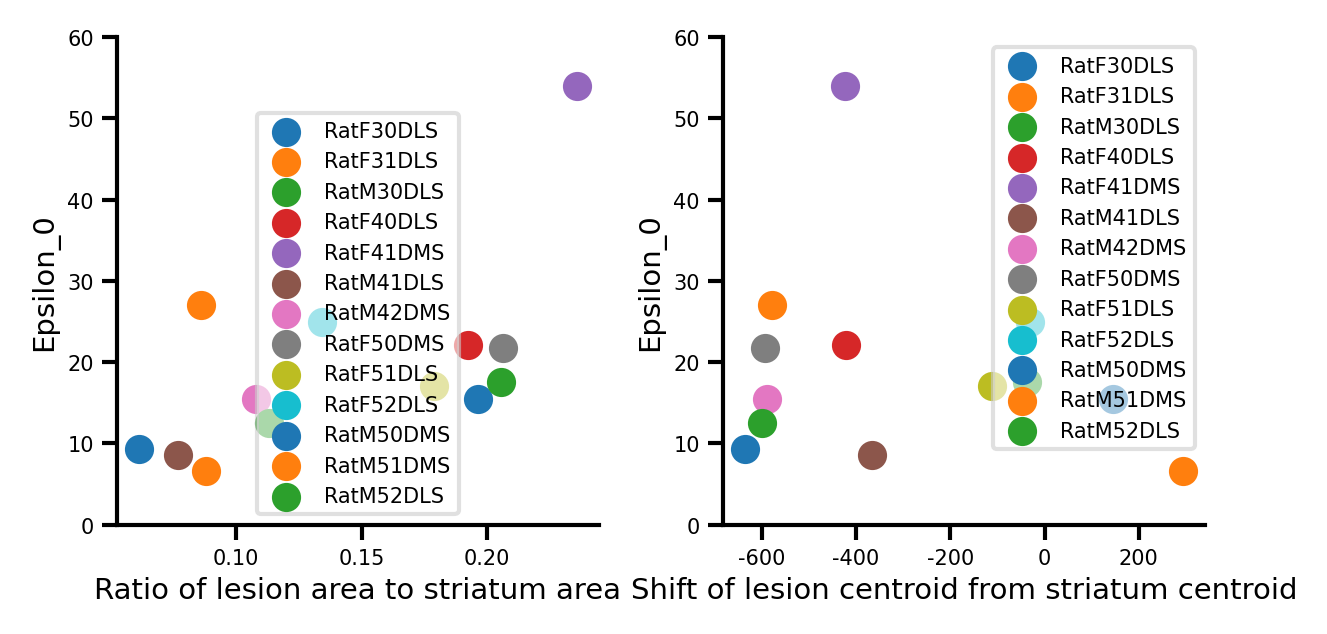

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
for animal in lesioned:
    axs[0].scatter(lesion_area[animal], epsilon_0[animal], label=animal+brainstatus[animal])
    axs[1].scatter(lesion_pos[animal], epsilon_0[animal], label=animal+brainstatus[animal])

axs[0].set_xlabel('Ratio of lesion area to striatum area')
axs[0].set_ylabel('Epsilon_0')
axs[0].legend()
axs[0].set_ylim(0, 60)

axs[1].set_xlabel('Shift of lesion centroid from striatum centroid')
axs[1].set_ylabel('Epsilon_0')
axs[1].legend()
axs[1].set_ylim(0, 60)

(0.0, 0.25)

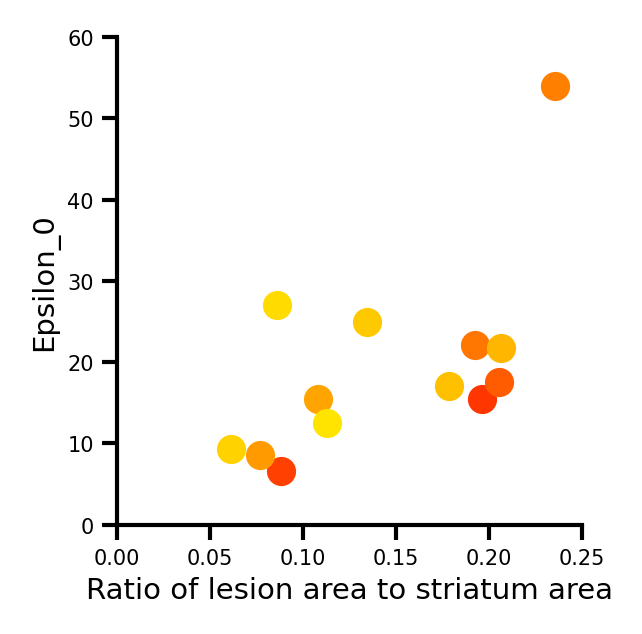

In [142]:
fig, ax = plt.subplots(figsize=(2, 2))
for animal in lesioned:
    ax.scatter(lesion_area[animal], epsilon_0[animal], label=animal, color=rat_markers[animal][0])
    # ax.scatter(0, epsilon_0[animal], label=animal, color=rat_markers[animal][0])


ax.set_xlabel('Ratio of lesion area to striatum area')
ax.set_ylabel('Epsilon_0')
# ax.legend()
ax.set_ylim(0, 60)
ax.set_xlim(0, 0.25)

In [143]:
lesion_area = pickle.load(open('picklejar/lesion_size', 'rb'))
# pickle.dump(lesion_area, open('picklejar/lesion_size', 'wb'))
lesion_area

{'RatF30': 0.19643901165126965,
 'RatF31': 0.08821956560196688,
 'RatM30': 0.2053259666773024,
 'RatF40': 0.19233649612363857,
 'RatF41': 0.23575508839542056,
 'RatM41': 0.07675401050733947,
 'RatM42': 0.10798724059249032,
 'RatF50': 0.20628089679112396,
 'RatF51': 0.1786343376776561,
 'RatF52': 0.13433576507914938,
 'RatM50': 0.06130521210715436,
 'RatM51': 0.08594412356323929,
 'RatM52': 0.11306180641067866}

epsilon_0 corr: 0.60, p: 0.0310
epsilon_t corr: 0.32, p: 0.2876
epsilon_R corr: 0.21, p: 0.4811
alpha_0 corr: 0.32, p: 0.2822
alpha_t corr: -0.51, p: 0.0762
alpha_R corr: 0.08, p: 0.7975
gamma_0 corr: -0.45, p: 0.1251
gamma_t corr: 0.21, p: 0.4847
gamma_R corr: 0.23, p: 0.4518
mu_0 corr: 0.73, p: 0.0045
mu_t corr: -0.07, p: 0.8118
mu_R corr: 0.45, p: 0.1191
sigma_0 corr: 0.75, p: 0.0033
sigma_t corr: -0.22, p: 0.4802
sigma_R corr: 0.19, p: 0.5334


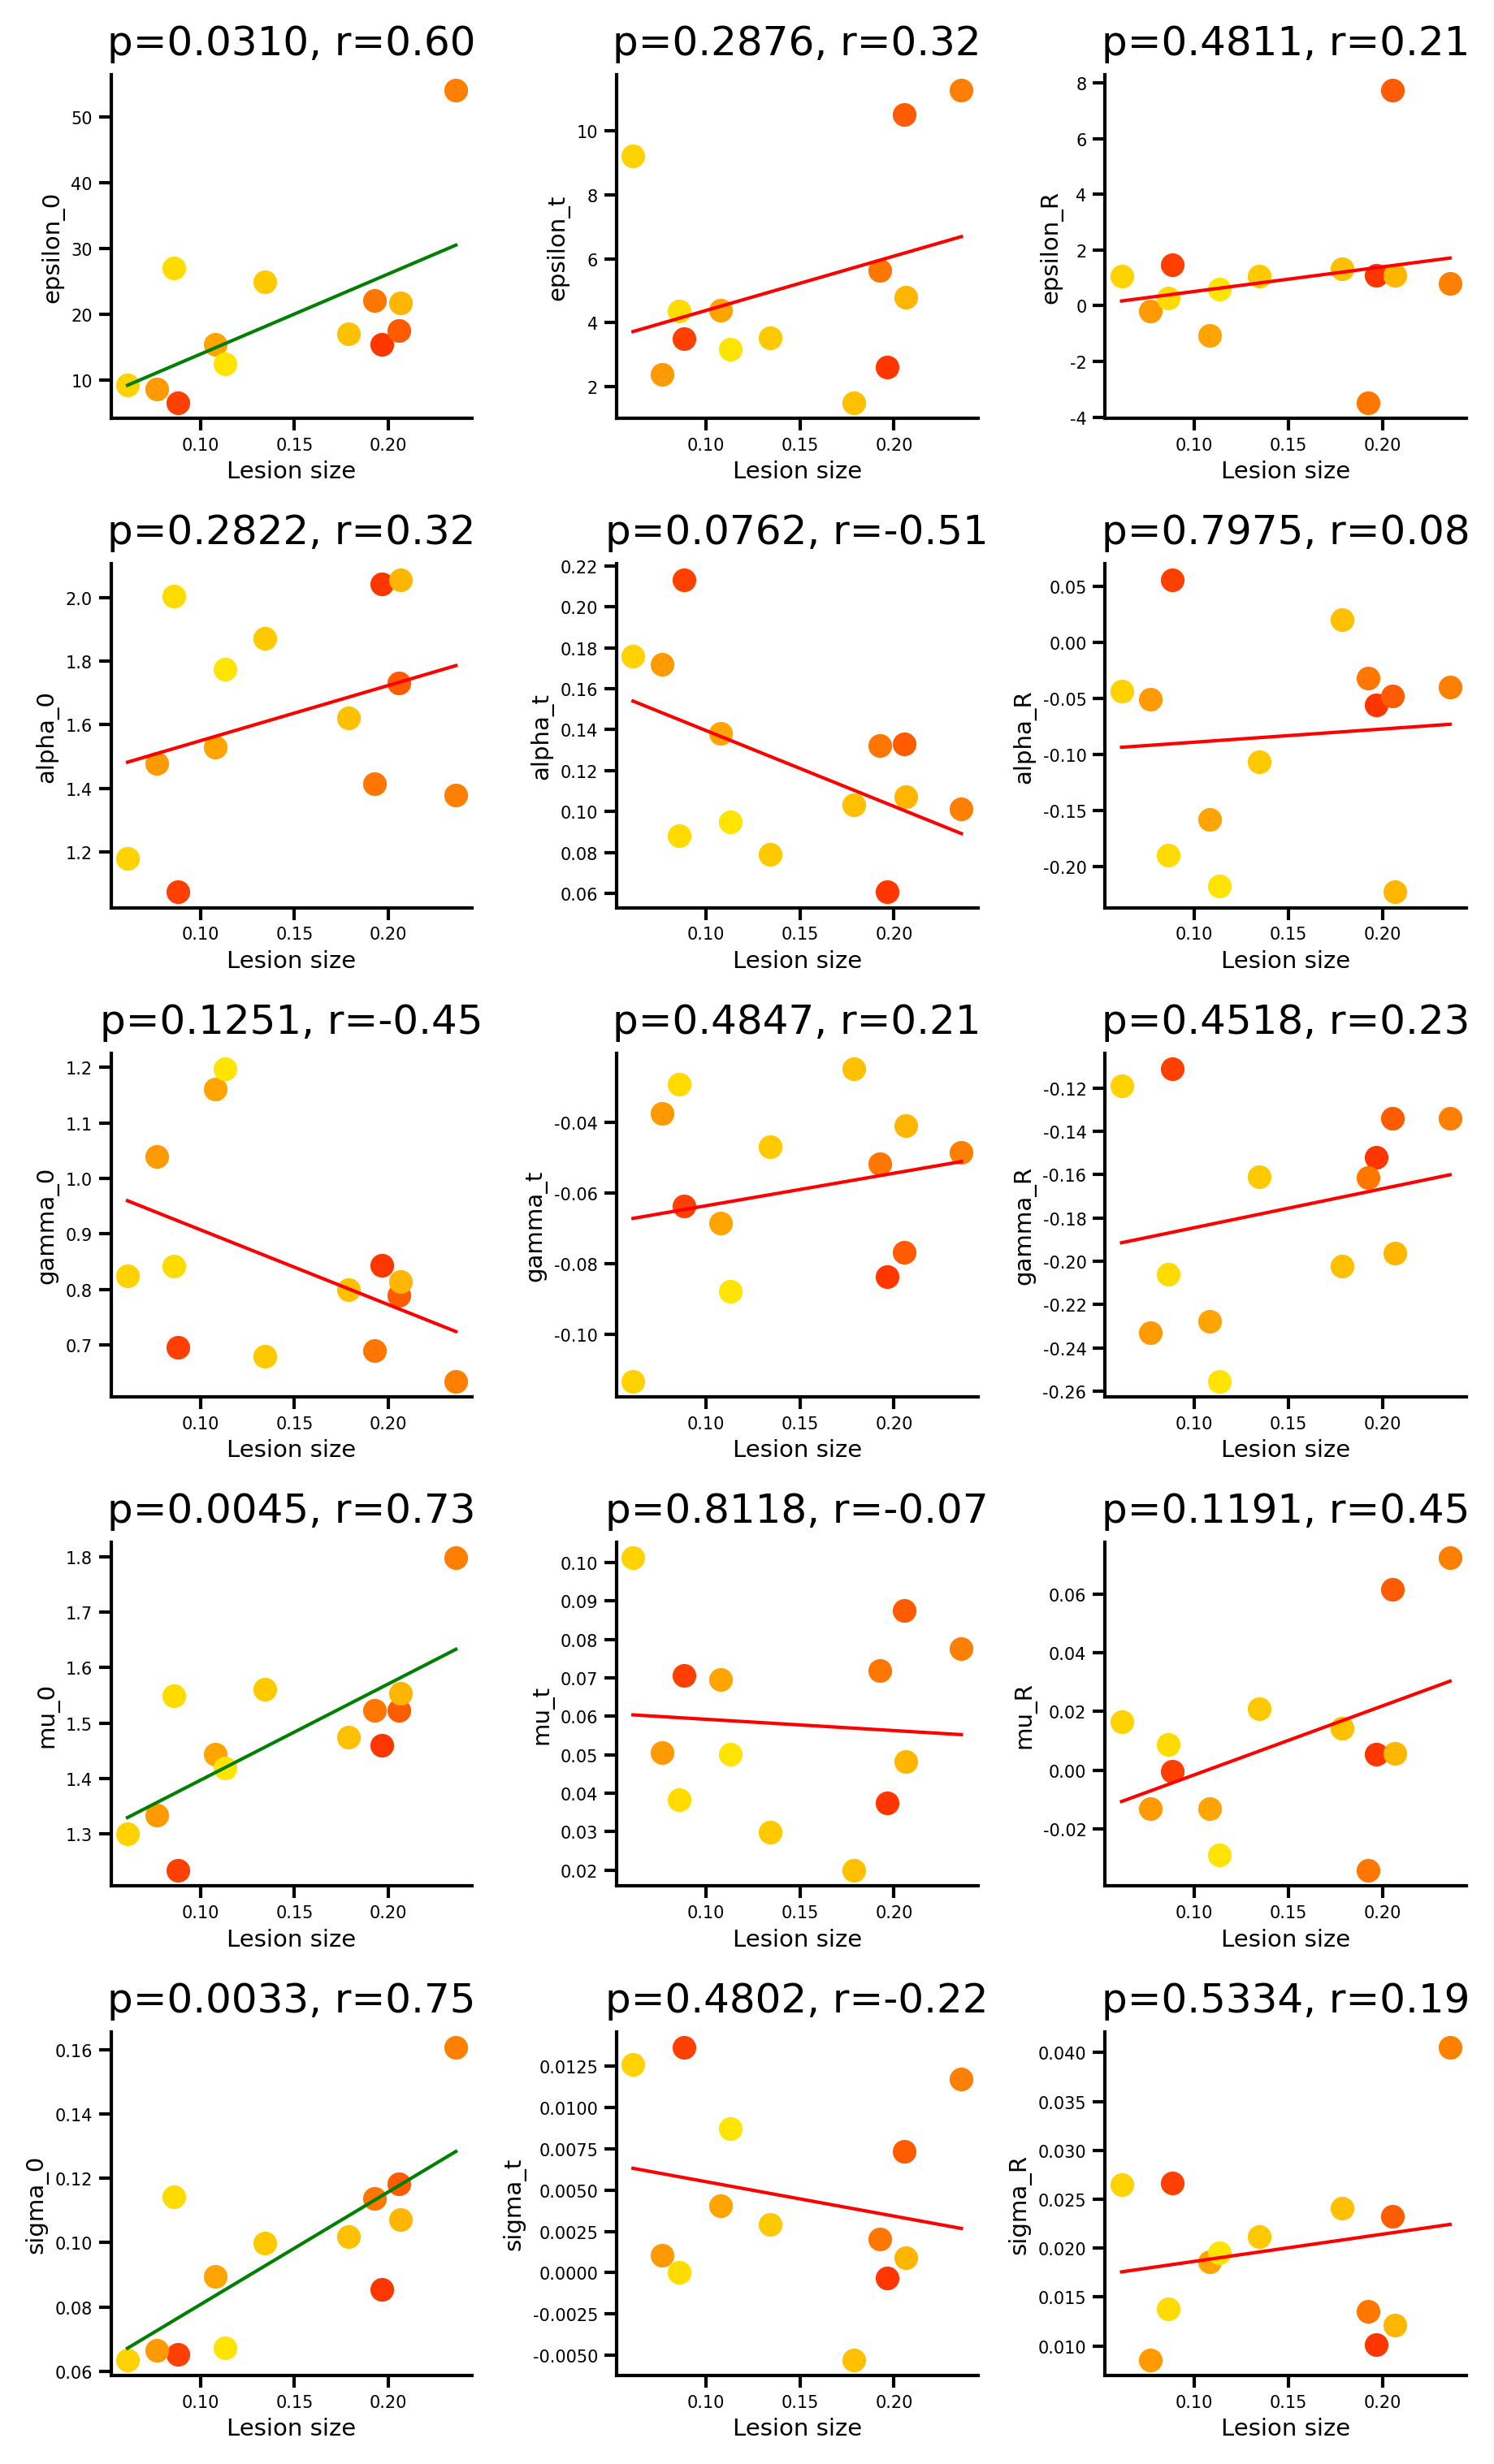

In [144]:
epsilon_0, epsilon_t, epsilon_R, power = pickle.load(open('picklejar/effort_fit.p', 'rb'))
alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
alpha_0 = {animal: np.median([alpha_0[animal][cond] for cond in conds]) for animal in lesioned}
alpha_t = {animal: np.median([alpha_t[animal][cond] for cond in conds]) for animal in lesioned}
alpha_R = {animal: np.median([alpha_R[animal][cond] for cond in conds]) for animal in lesioned}
gamma_0 = {animal: np.median([gamma_0[animal][cond] for cond in conds]) for animal in lesioned}
gamma_t = {animal: np.median([gamma_t[animal][cond] for cond in conds]) for animal in lesioned}
gamma_R = {animal: np.median([gamma_R[animal][cond] for cond in conds]) for animal in lesioned}
mu_0 = {animal: np.median([mu_0[animal][cond] for cond in conds]) for animal in lesioned}
mu_t = {animal: np.median([mu_t[animal][cond] for cond in conds]) for animal in lesioned}
mu_R = {animal: np.median([mu_R[animal][cond] for cond in conds]) for animal in lesioned}
sigma_0 = {animal: np.median([sigma_0[animal][cond] for cond in conds]) for animal in lesioned}
sigma_t = {animal: np.median([sigma_t[animal][cond] for cond in conds]) for animal in lesioned}
sigma_R = {animal: np.median([sigma_R[animal][cond] for cond in conds]) for animal in lesioned}

vars = [epsilon_0, epsilon_t, epsilon_R, alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R]
names = ['epsilon_0', 'epsilon_t', 'epsilon_R', 'alpha_0', 'alpha_t', 'alpha_R', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t', 'mu_R', 'sigma_0', 'sigma_t', 'sigma_R']

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_area[animal], var[animal], label=animal, color=rat_markers[animal][0])
        x.append(lesion_area[animal])
        y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion size')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')




k corr: 0.62, p: 0.0235
effort corr: -0.35, p: 0.2392


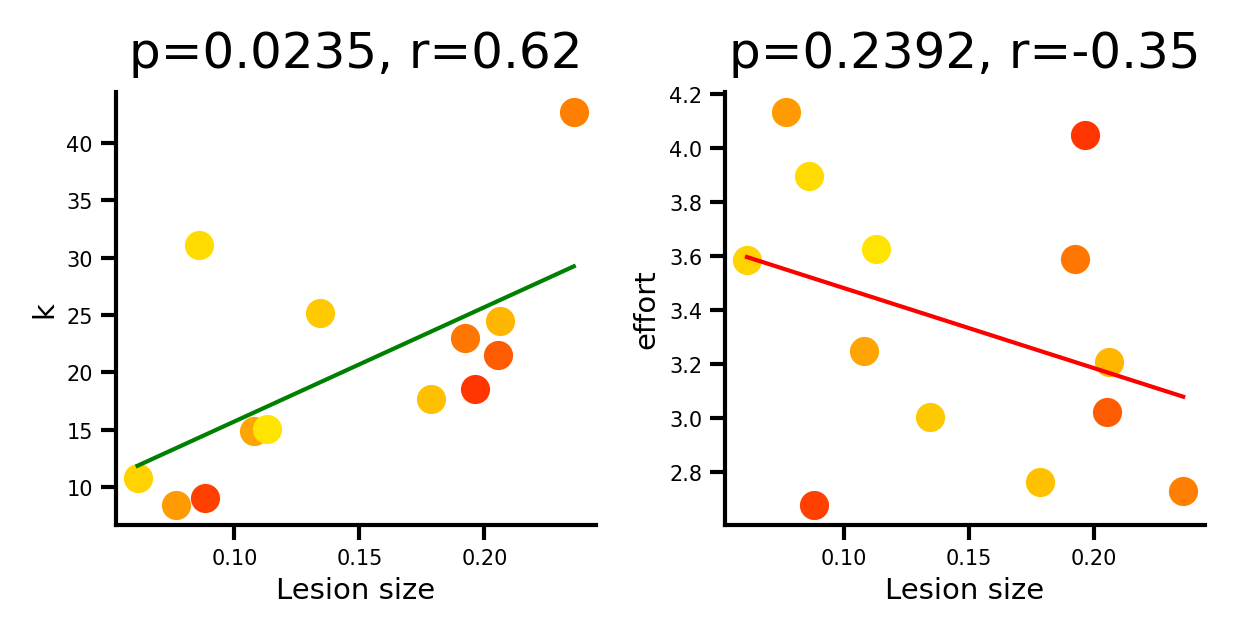

In [145]:

vars = [k, effort,]
names = ['k', 'effort']

fig, axs = plt.subplots(1, 2, figsize=(4, 2))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in lesioned:
        ax.scatter(lesion_area[animal], var[animal], label=animal, color=rat_markers[animal][0])
        x.append(lesion_area[animal])
        y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion size')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')




In [146]:
k, effort = pickle.load(open('picklejar/TESTFREEeffort_fit.p', 'rb'))

k corr: -0.18, p: 0.5586
effort corr: -0.33, p: 0.2754


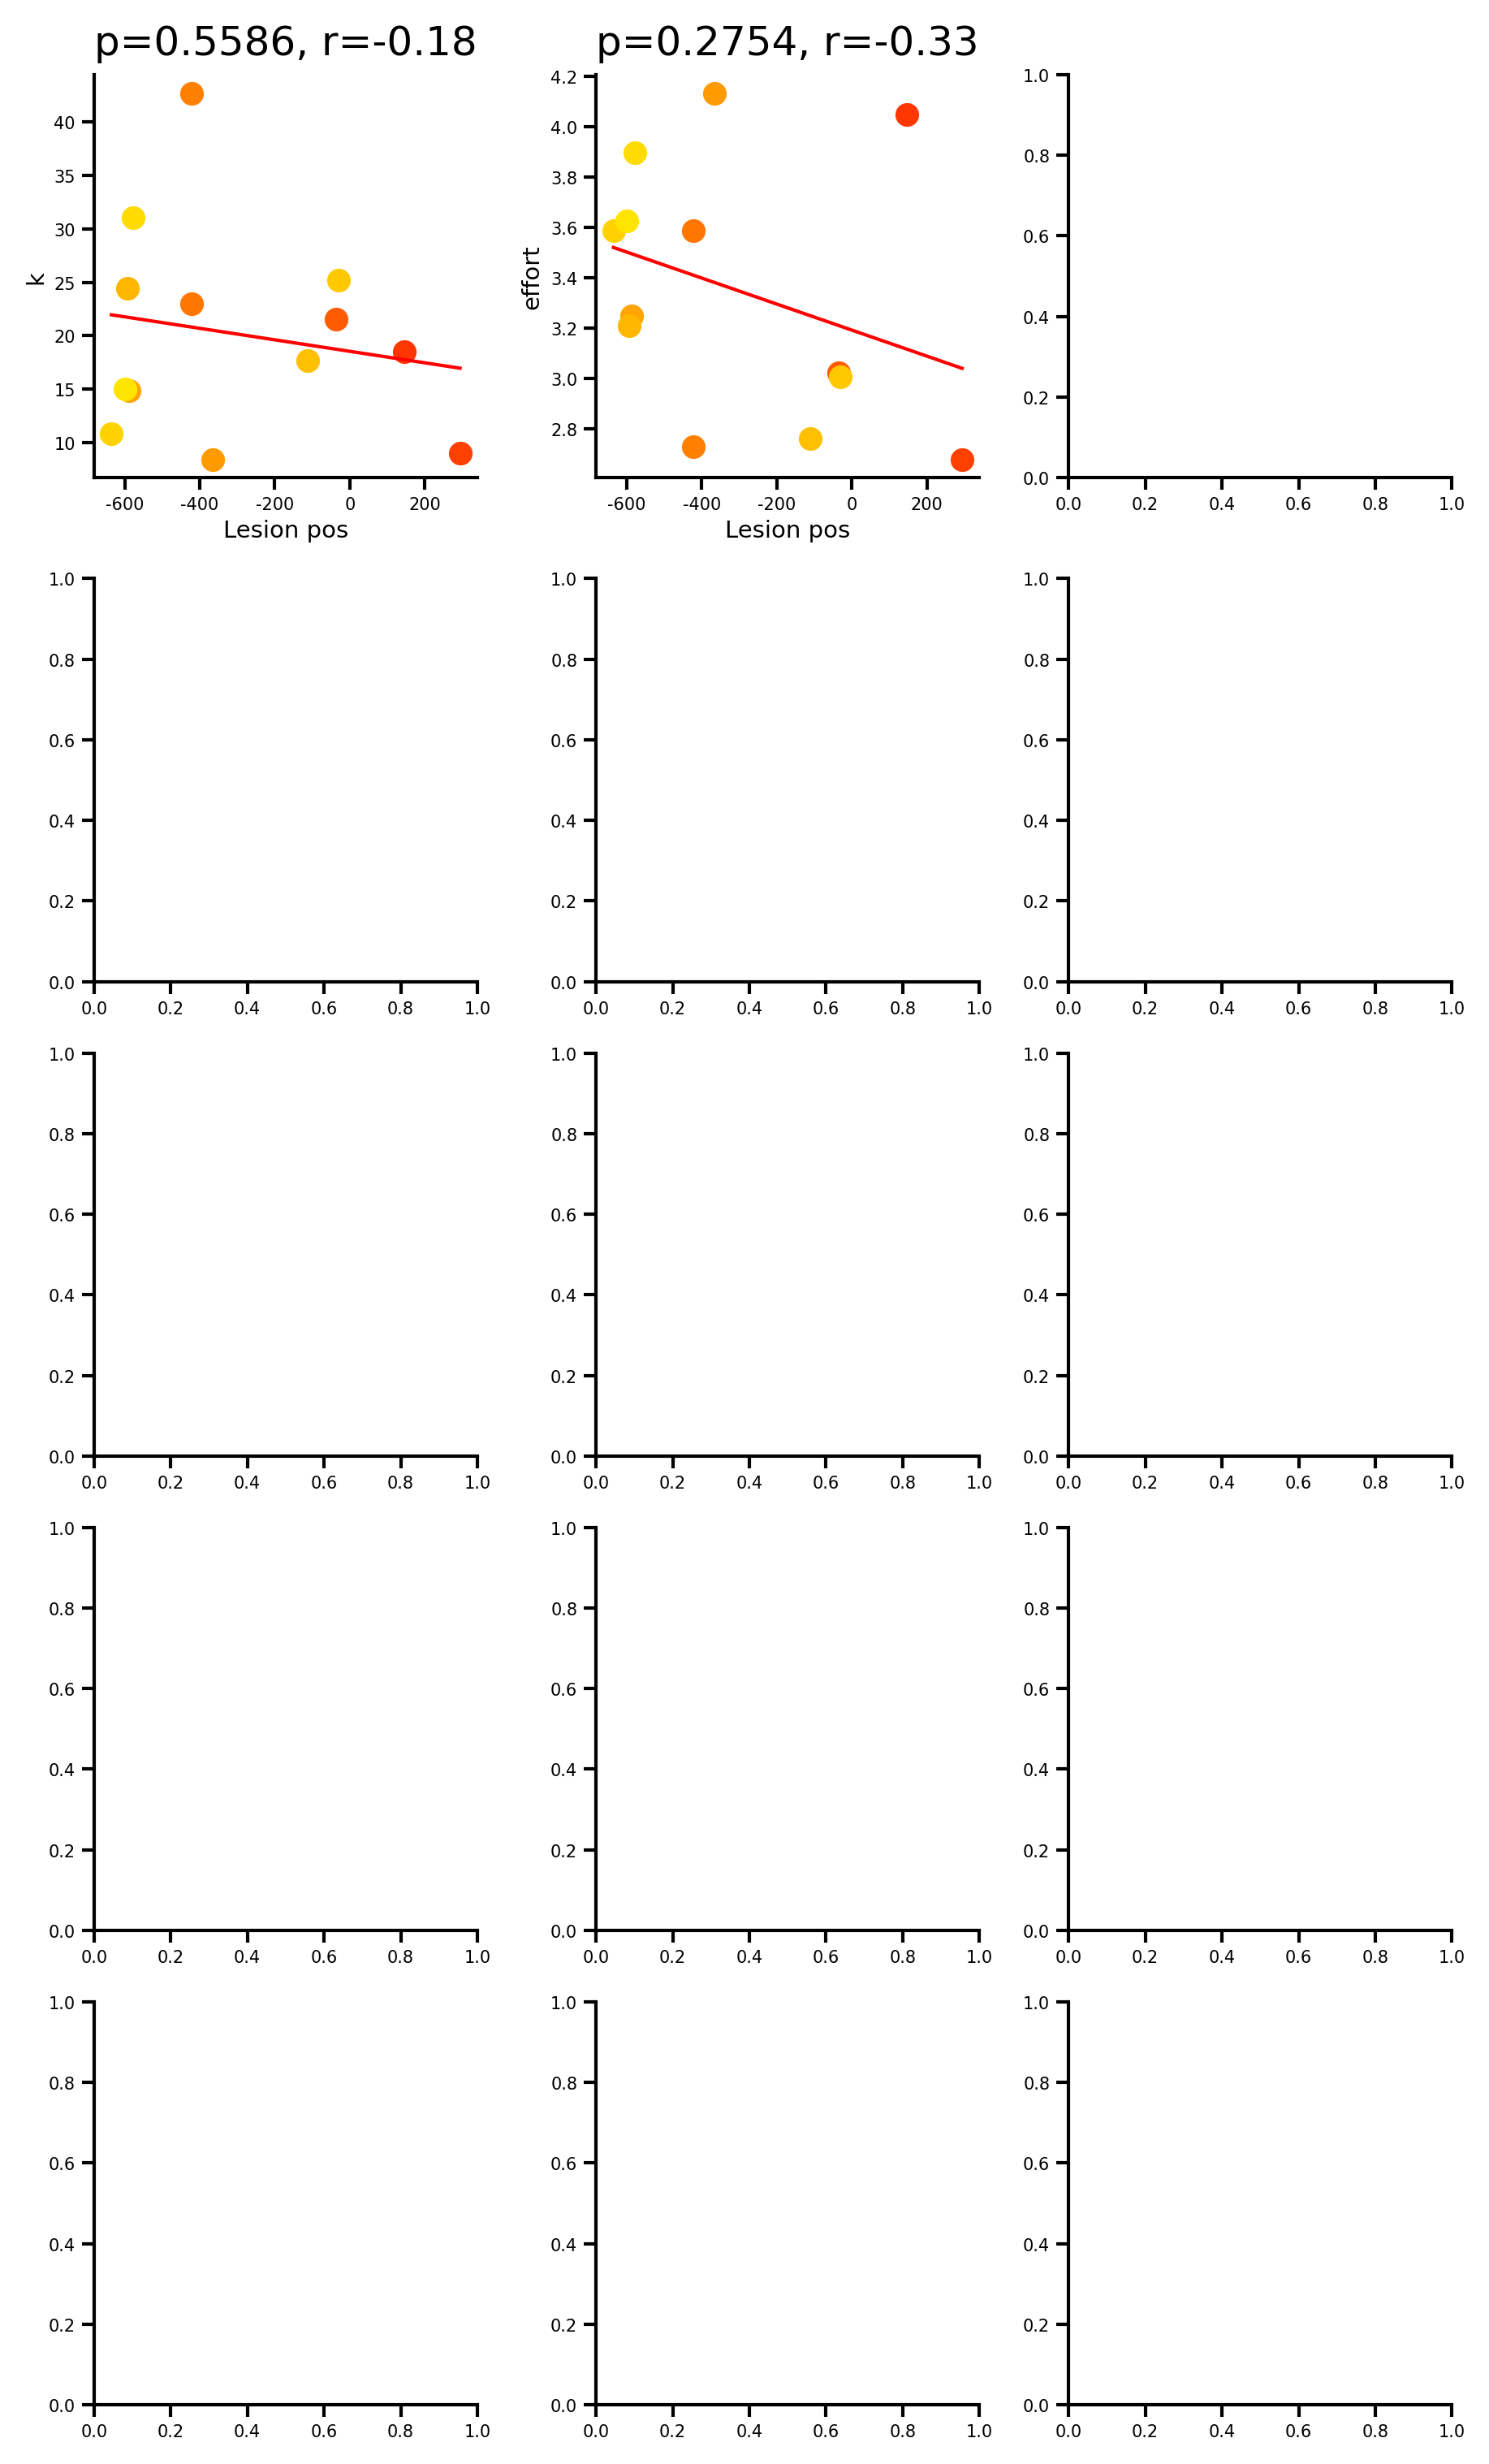

In [147]:

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in lesioned:
        try:
            ax.scatter(lesion_pos[animal], var[animal], label=animal, color=rat_markers[animal][0])
            x.append(lesion_pos[animal])
            y.append(var[animal])
        
        except KeyError:
            pass

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion pos')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')




In [148]:
# epsilon_0, epsilon_t, epsilon_R = pickle.load(open('picklejar/effort_fit.p', 'rb'))

# fig, axs = plt.subplots(1, 1, figsize=(2, 2))
# ylabels = [r'$\epsilon_0$', r"$\epsilon_t$", r"$\epsilon_R$"]
# ylims = [[-.2, 2.5], [-.05, .2], [-.15, .15],]


# epsilon_0_intact = []
# epsilon_t_intact = []
# epsilon_R_intact = []

# epsilon_0_lesion = []
# epsilon_t_lesion = []
# epsilon_R_lesion = []

# for animal in lesioned:
    
#     x = np.arange(3)
#     epsilon_0_intact.append(epsilon_0[animal])
#     epsilon_t_intact.append(epsilon_t[animal])
#     epsilon_R_intact.append(epsilon_R[animal])

#     print(epsilon_0[animal], epsilon_t[animal], epsilon_R[animal])
#     axs.scatter(x,  [epsilon_0[animal], epsilon_t[animal], epsilon_R[animal]], color=rat_markers[animal][0], s=50)
#     axs.set_title(f"")
#     axs.set_xticks(np.arange(3))
#     axs.set_xticklabels(ylabels)
#     axs.set_xlim(-.5, 2.5)
#     # axs.set_ylim(ylim)
#     axs.axhline(0, color='black', linestyle='--', linewidth=1)

# axs.set_xlabel("effort sensibility parameter")



# Fig params comparison intact lesion

In [149]:
alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
vars = [alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R]
names = ['alpha_0', 'alpha_t', 'alpha_R', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t', 'mu_R', 'sigma_0', 'sigma_t', 'sigma_R']


import scipy.stats as stats

def compare_intact_lesion(var):
    group1 = [var[animal][cond] for cond in conds for animal in animalList if brainstatus[animal] == 'normal']
    group2 = [var[animal][cond] for cond in conds for animal in animalList if brainstatus[animal] != 'normal']
    print(np.mean(group1), np.mean(group2))
    # Check normality
    _, p_value_group1 = stats.shapiro(group1)
    _, p_value_group2 = stats.shapiro(group2)

    alpha = 0.05 
    if p_value_group1 < alpha or p_value_group2 < alpha:
        u_stat, p_value = stats.mannwhitneyu(group1, group2)

        if p_value < alpha:
            print("diff (MWU)", p_value)
        else:
            print("NO diff (MWU)", p_value)

    else:
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)

        if p_value < alpha:
            print("diff (ttest)", p_value)
        else:
            print("NO diff (ttest)", p_value)

    # perm = exact_mc_perm_test(group1, group2)
    # print("diff (perm)", perm)

for var, name in zip(vars, names):
    print(name)
    compare_intact_lesion(var)
    print()

alpha_0
1.4022579363810512 1.5715178272937143
diff (ttest) 0.003344693255320957

alpha_t
0.17059440171827886 0.1244992992130872
diff (MWU) 3.3549750257642545e-05

alpha_R
-0.0782952478635868 -0.07539120958890806
NO diff (MWU) 0.897197142303075

gamma_0
0.8560508230596967 0.8559474028738099
NO diff (ttest) 0.997696452394409

gamma_t
-0.06173284007193987 -0.06004197427385376
NO diff (MWU) 0.49577188907824876

gamma_R
-0.17408378712985187 -0.1755199450203762
NO diff (MWU) 0.4388223029870496

mu_0
1.309899930719816 1.4466426680737698
diff (MWU) 0.00013274819118357878

mu_t
0.06368068889282383 0.057113740030602225
NO diff (MWU) 0.06122170303428324

mu_R
0.00046076186655258556 0.007297906634715138
NO diff (MWU) 0.30862167000791174

sigma_0
0.08610361763627843 0.0979926276514263
diff (MWU) 0.016624717360482474

sigma_t
0.007531110901098182 0.004976409170782025
NO diff (MWU) 0.05705365330721336

sigma_R
0.024247515523409556 0.022242251256177754
NO diff (MWU) 0.05841596484084364



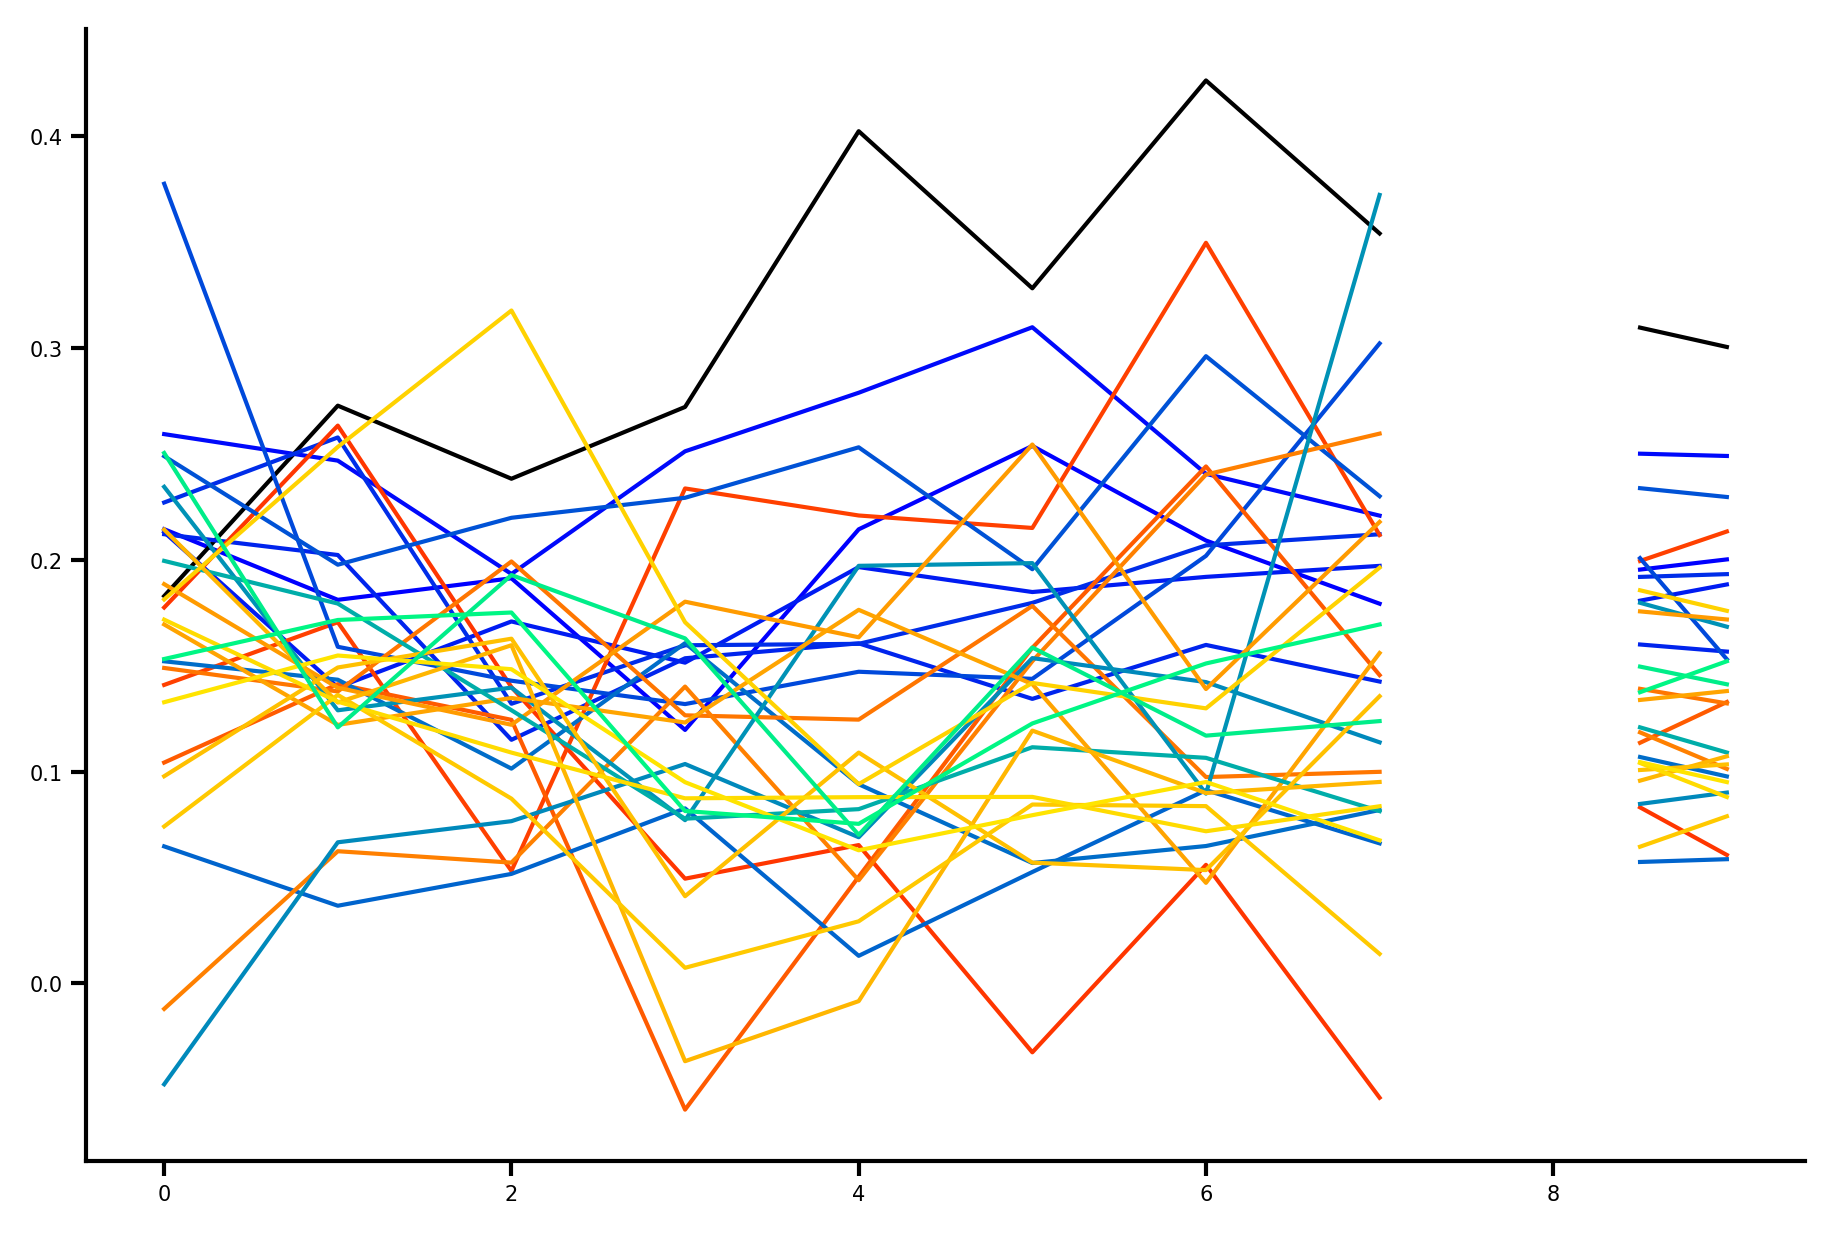

In [150]:
alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))


for animal in animalList:
    plt.plot(np.arange(8), [alpha_t[animal][cond] for cond in conds], color=rat_markers[animal][0],)
    # plt.scatter(8.5, , s=50)
    plt.plot((8.5, 9), 
                (np.mean([alpha_t[animal][cond] for cond in conds]), 
                 np.median([alpha_t[animal][cond] for cond in conds])), color=rat_markers[animal][0], )

In [151]:
epsilon_0, epsilon_t, epsilon_R, power = pickle.load(open('picklejar/effort_fit.p', 'rb'))
alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
alpha_0 = {animal: np.median([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
alpha_t = {animal: np.median([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
alpha_R = {animal: np.median([alpha_R[animal][cond] for cond in conds]) for animal in animalList}
gamma_0 = {animal: np.median([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
gamma_t = {animal: np.median([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
gamma_R = {animal: np.median([gamma_R[animal][cond] for cond in conds]) for animal in animalList}
mu_0 = {animal: np.median([mu_0[animal][cond] for cond in conds]) for animal in animalList}
mu_t = {animal: np.median([mu_t[animal][cond] for cond in conds]) for animal in animalList}
mu_R = {animal: np.median([mu_R[animal][cond] for cond in conds]) for animal in animalList}
sigma_0 = {animal: np.median([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
sigma_t = {animal: np.median([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
sigma_R = {animal: np.median([sigma_R[animal][cond] for cond in conds]) for animal in animalList}

vars = [epsilon_0, epsilon_t, epsilon_R, alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R]
names = ['epsilon_0', 'epsilon_t', 'epsilon_R', 'alpha_0', 'alpha_t', 'alpha_R', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t', 'mu_R', 'sigma_0', 'sigma_t', 'sigma_R']


In [152]:
# epsilon_0, epsilon_t, epsilon_R = pickle.load(open('picklejar/effort_fit.p', 'rb'))
# alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

# conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
# alpha_0 = {animal: np.mean([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
# alpha_t = {animal: np.mean([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
# alpha_R = {animal: np.mean([alpha_R[animal][cond] for cond in conds]) for animal in animalList}
# gamma_0 = {animal: np.mean([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
# gamma_t = {animal: np.mean([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
# gamma_R = {animal: np.mean([gamma_R[animal][cond] for cond in conds]) for animal in animalList}
# mu_0 = {animal: np.mean([mu_0[animal][cond] for cond in conds]) for animal in animalList}
# mu_t = {animal: np.mean([mu_t[animal][cond] for cond in conds]) for animal in animalList}
# mu_R = {animal: np.mean([mu_R[animal][cond] for cond in conds]) for animal in animalList}
# sigma_0 = {animal: np.mean([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
# sigma_t = {animal: np.mean([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
# sigma_R = {animal: np.mean([sigma_R[animal][cond] for cond in conds]) for animal in animalList}

# vars = [epsilon_0, epsilon_t, epsilon_R, alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R]
# names = ['epsilon_0', 'epsilon_t', 'epsilon_R', 'alpha_0', 'alpha_t', 'alpha_R', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t', 'mu_R', 'sigma_0', 'sigma_t', 'sigma_R']


In [153]:
# #test normalized
# def compute_intercept(var, animalList=animalList, conds=conds):

#     x = np.arange(len(conds))
#     expected_values = {cond: np.mean([var[animal][cond] for animal in animalList]) for cond in conds}
#     individual_intercepts = {}

#     for animal in animalList:
#         # compute expected value for each condition
#         y = np.array([var[animal][cond] for cond in conds])
#         y_expected = y - np.array([expected_values[cond] for cond in conds])

#         # compute intercept for each animal
#         X = np.ones((len(x), 1))
#         coefficients = np.linalg.lstsq(X, y_expected.reshape(-1, 1), rcond=None)[0]
#         intercept = coefficients[0][0]
#         individual_intercepts[animal] = intercept

#     return individual_intercepts


# epsilon_0, epsilon_t, epsilon_R = pickle.load(open('picklejar/effort_fit.p', 'rb'))
# alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

# conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
# alpha_0 = compute_intercept(alpha_0)
# alpha_t = compute_intercept(alpha_t)
# alpha_R = compute_intercept(alpha_R)
# gamma_0 = compute_intercept(gamma_0)
# gamma_t = compute_intercept(gamma_t)
# gamma_R = compute_intercept(gamma_R)
# mu_0 = compute_intercept(mu_0)
# mu_t = compute_intercept(mu_t)
# mu_R = compute_intercept(mu_R)
# sigma_0 = compute_intercept(sigma_0)
# sigma_t = compute_intercept(sigma_t)
# sigma_R = compute_intercept(sigma_R)


# vars = [epsilon_0, epsilon_t, epsilon_R, alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R]
# names = ['epsilon_0', 'epsilon_t', 'epsilon_R', 'alpha_0', 'alpha_t', 'alpha_R', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t', 'mu_R', 'sigma_0', 'sigma_t', 'sigma_R']


epsilon_0 0.0249
epsilon_t 0.3436
epsilon_R 0.6329


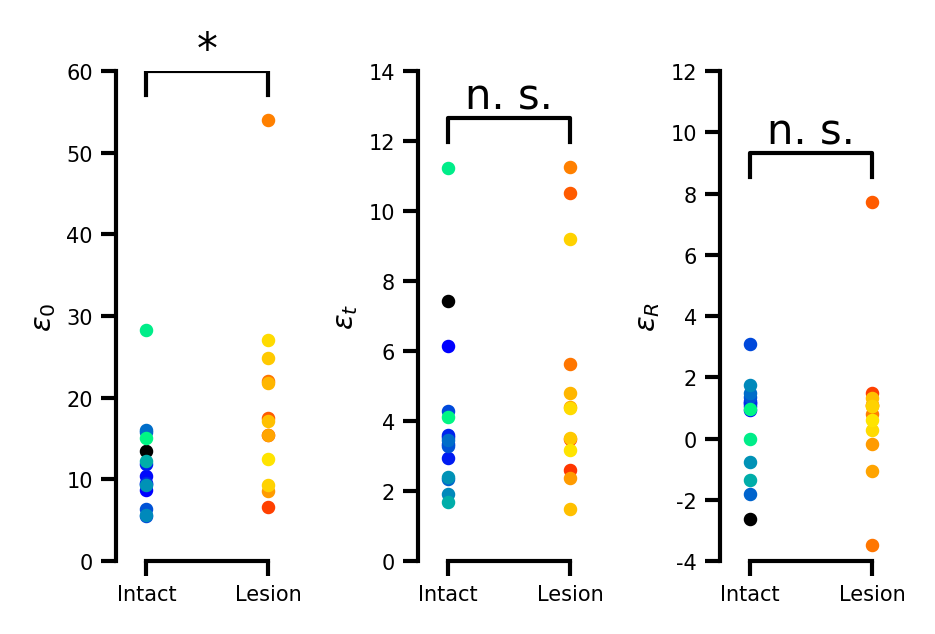

In [154]:
def Figure6_A(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(epsilon_0[animal])
            x = 0
        else:
            lesion.append(epsilon_0[animal])
            x = 1
        ax.scatter(x, epsilon_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 60)
    ax.set_ylabel(r'$\epsilon_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("epsilon_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_B(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(epsilon_t[animal])
            x = 0
        else:
            lesion.append(epsilon_t[animal])
            x = 1
        ax.scatter(x, epsilon_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 14)
    ax.set_ylabel(r'$\epsilon_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("epsilon_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_C(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(epsilon_R[animal])
            x = 0
        else:
            lesion.append(epsilon_R[animal])
            x = 1
        ax.scatter(x, epsilon_R[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-4, 12)
    ax.set_ylabel(r'$\epsilon_R$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("epsilon_R", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_A(axs[0])
Figure6_B(axs[1])
Figure6_C(axs[2])

alpha_0 0.236
alpha_t 0.0508
alpha_t MWU 0.05893484040214102
alpha_R 0.7064


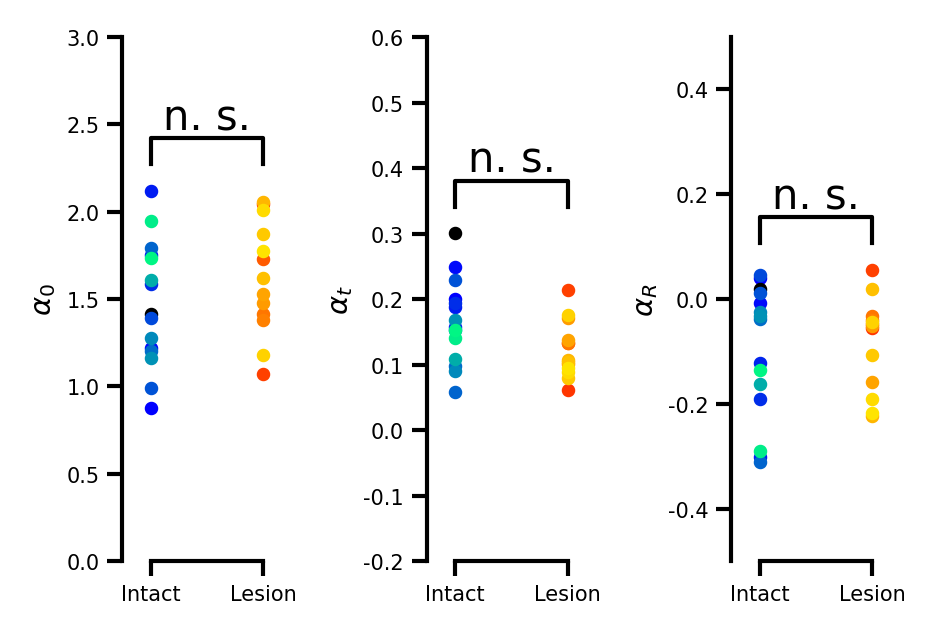

In [155]:
def Figure6_D(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(alpha_0[animal])
            x = 0
        else:
            lesion.append(alpha_0[animal])
            x = 1
        ax.scatter(x, alpha_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\alpha_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("alpha_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_E(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(alpha_t[animal])
            x = 0
        else:
            lesion.append(alpha_t[animal])
            x = 1
        ax.scatter(x, alpha_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.2, .6)
    ax.set_ylabel(r'$\alpha_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion, 10000)
    print("alpha_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

    t_stat, p_value = stats.mannwhitneyu(intact, lesion)
    print("alpha_t MWU", p_value)


def Figure6_F(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(alpha_R[animal])
            x = 0
        else:
            lesion.append(alpha_R[animal])
            x = 1
        ax.scatter(x, alpha_R[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.5, .5)
    ax.set_ylabel(r'$\alpha_R$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("alpha_R", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_D(axs[0])
Figure6_E(axs[1])
Figure6_F(axs[2])

gamma_0 0.8396
gamma_t 0.7304
gamma_R 0.9231


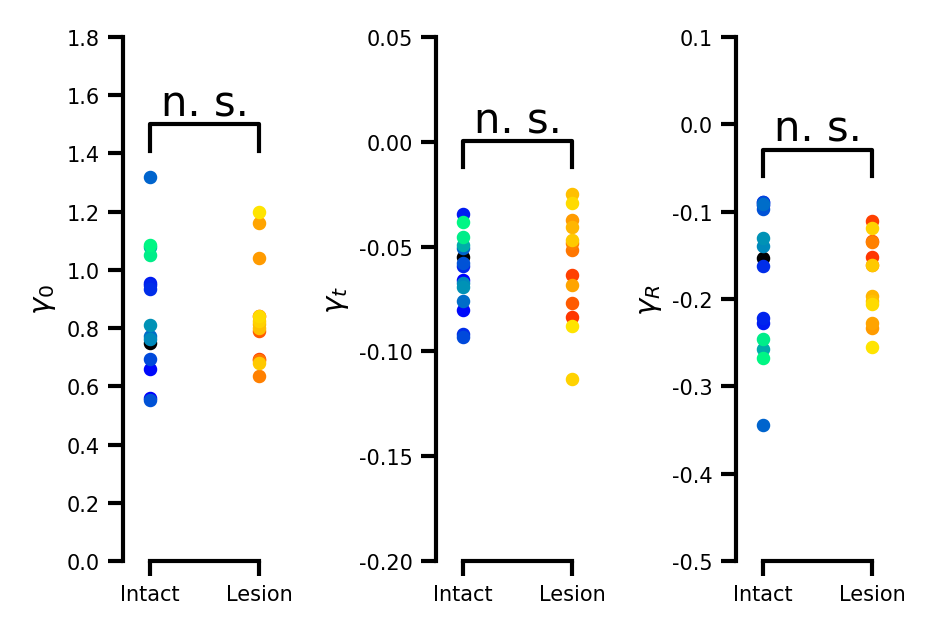

In [156]:
def Figure6_G(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(gamma_0[animal])
            x = 0
        else:
            lesion.append(gamma_0[animal])
            x = 1
        ax.scatter(x, gamma_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.8)
    ax.set_ylabel(r'$\gamma_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("gamma_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)


def Figure6_H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(gamma_t[animal])
            x = 0
        else:
            lesion.append(gamma_t[animal])
            x = 1
        ax.scatter(x, gamma_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.2, 0.05)
    ax.set_ylabel(r'$\gamma_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("gamma_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(gamma_R[animal])
            x = 0
        else:
            lesion.append(gamma_R[animal])
            x = 1
        ax.scatter(x, gamma_R[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, .1)
    ax.set_ylabel(r'$\gamma_R$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("gamma_R", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_G(axs[0])
Figure6_H(axs[1])
Figure6_I(axs[2])

sigma_0 0.147
sigma_t 0.3322
sigma_R 0.5274


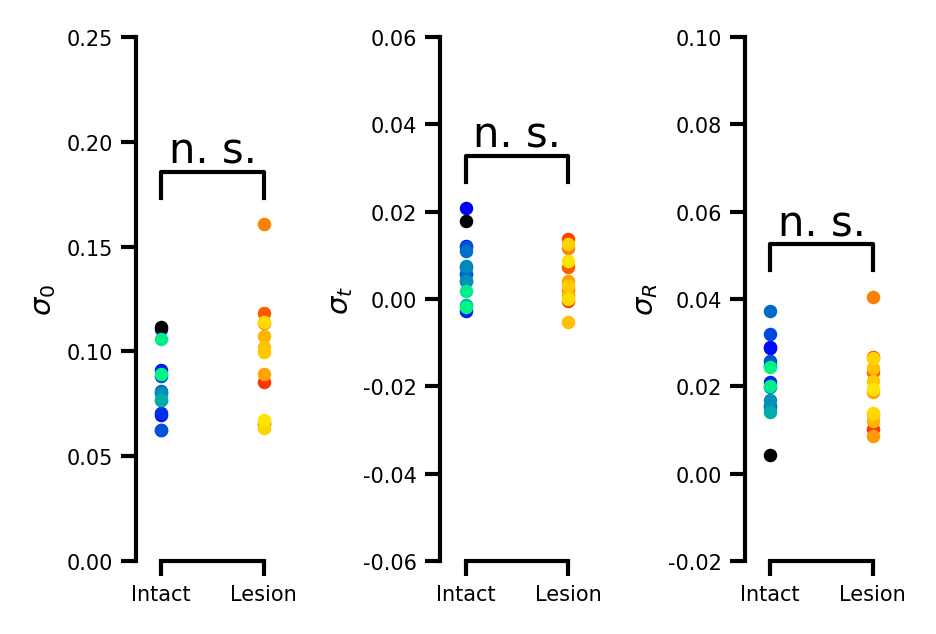

In [157]:
def Figure6_J(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(sigma_0[animal])
            x = 0
        else:
            lesion.append(sigma_0[animal])
            x = 1
        ax.scatter(x, sigma_0[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, .25)
    ax.set_ylabel(r'$\sigma_0$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("sigma_0", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)


def Figure6_K(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(sigma_t[animal])
            x = 0
        else:
            lesion.append(sigma_t[animal])
            x = 1
        ax.scatter(x, sigma_t[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-.06, 0.06)
    ax.set_ylabel(r'$\sigma_t$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("sigma_t", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)

def Figure6_L(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    intact, lesion = [], []
    for animal in animalList:
        if brainstatus[animal] == 'normal':
            intact.append(sigma_R[animal])
            x = 0
        else:
            lesion.append(sigma_R[animal])
            x = 1
        ax.scatter(x, sigma_R[animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Intact', 'Lesion'])
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, .1)
    ax.set_ylabel(r'$\sigma_R$')
    space_axes(ax, y_ratio=.0, x_ratio_left=.25, x_ratio_right=.25)

    perm = exact_mc_perm_test(intact, lesion)
    print("sigma_R", perm)
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [np.max(intact), np.max(lesion)], maxasterix=None)
        
fig, axs = plt.subplots(1, 3, figsize=(3, 2))

Figure6_J(axs[0])
Figure6_K(axs[1])
Figure6_L(axs[2])

In [158]:
realdist60 = {}
realdist90 = {}
realdist120= {}
realdist20= {}
realdistrev20= {}

# compute the running distance for each run (pos start - pos end) for each distance configuration
for animal in animalList:
    realdist60[animal], realdist90[animal], realdist120[animal] = ([] for _ in range(3))
    realdist20[animal], realdistrev20[animal] = ([] for _ in range(2))
    for session in sorted(matchsession(animal, dist60)):
        for i in range(0, 12):
            realdist60[animal] = np.append(realdist60[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist60[animal] = np.append(realdist60[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist90)):   
        for i in range(0, 12):
            realdist90[animal] = np.append(realdist90[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist90[animal] = np.append(realdist90[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, dist120)):
        for i in range(0, 12):
            realdist120[animal] = np.append(realdist120[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist120[animal] = np.append(realdist120[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])

    for session in sorted(matchsession(animal, TM20)):
        for i in range(0, 12):
            realdist20[animal] = np.append(realdist20[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdist20[animal] = np.append(realdist20[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
    for session in sorted(matchsession(animal, TMrev20)):
        for i in range(0, 12):
            realdistrev20[animal] = np.append(realdistrev20[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
            realdistrev20[animal] = np.append(realdistrev20[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])



# compute the mean running distance for each animal for each distance configuration
medianrealdist60 = {}
medianrealdist90 = {}
medianrealdist120 = {}
medianrealdist20 = {}
medianrealdistrev20 = {}

for animal in animalList:
    medianrealdist60[animal] = np.median(realdist60[animal]) / 100
    medianrealdist90[animal] = np.median(realdist90[animal]) / 100
    medianrealdist120[animal] = np.median(realdist120[animal]) / 100
    medianrealdist20[animal] = np.median(realdist20[animal]) / 100
    medianrealdistrev20[animal] = np.median(realdistrev20[animal]) / 100

# # compute the mean running distance for each distance configuration
# medianrealdist60 = np.median([medianrealdist60[animal] for animal in animalList])
# medianrealdist90 = np.median([medianrealdist90[animal] for animal in animalList])
# medianrealdist120 = np.median([medianrealdist120[animal] for animal in animalList])
# medianrealdist20 = np.median([medianrealdist20[animal] for animal in animalList])
# medianrealdistrev20 = np.median([medianrealdistrev20[animal] for animal in animalList])

# print('mean real distance for 60cm: ', medianrealdist60)
# print('mean real distance for 90cm: ', medianrealdist90)
# print('mean real distance for 120cm: ', medianrealdist120)
# # print('mean real distance for TM 20: ', meanrealdist20)
# # print('mean real distance for TM -20: ', meanrealdistrev20)

In [184]:
median_intact_rat = np.median([epsilon_0[animal] for animal in animalList if brainstatus[animal] == 'normal'])
interquartile_intact_rat = np.percentile([epsilon_0[animal] for animal in animalList if brainstatus[animal] == 'normal'], 75) - np.percentile([epsilon_0[animal] for animal in animalList if brainstatus[animal] == 'normal'], 25)
# sterr_intact_rat = np.std([epsilon_0[animal] for animal in animalList if brainstatus[animal] == 'normal']) / np.sqrt(len([epsilon_0[animal] for animal in animalList if brainstatus[animal] == 'normal']))

median_lesion_rat = np.median([epsilon_0[animal] for animal in animalList if brainstatus[animal] != 'normal'])
interquartile_lesion_rat = np.percentile([epsilon_0[animal] for animal in animalList if brainstatus[animal] != 'normal'], 75) - np.percentile([epsilon_0[animal] for animal in animalList if brainstatus[animal] != 'normal'], 25)
# sterr_lesion_rat = np.std([epsilon_0[animal] for animal in animalList if brainstatus[animal] != 'normal']) / np.sqrt(len([epsilon_0[animal] for animal in animalList if brainstatus[animal] != 'normal']))

print(f'Intact: {median_intact_rat} IQR: {interquartile_intact_rat}')
print(f'Lesion: {median_lesion_rat} IQR: {interquartile_lesion_rat}')

Intact: 10.420143656811938 IQR: 5.246012864028229
Lesion: 17.097240149020212 IQR: 9.62112495302338


In [160]:
rat_example_lesion = 'RatF52' # 'RatF50'

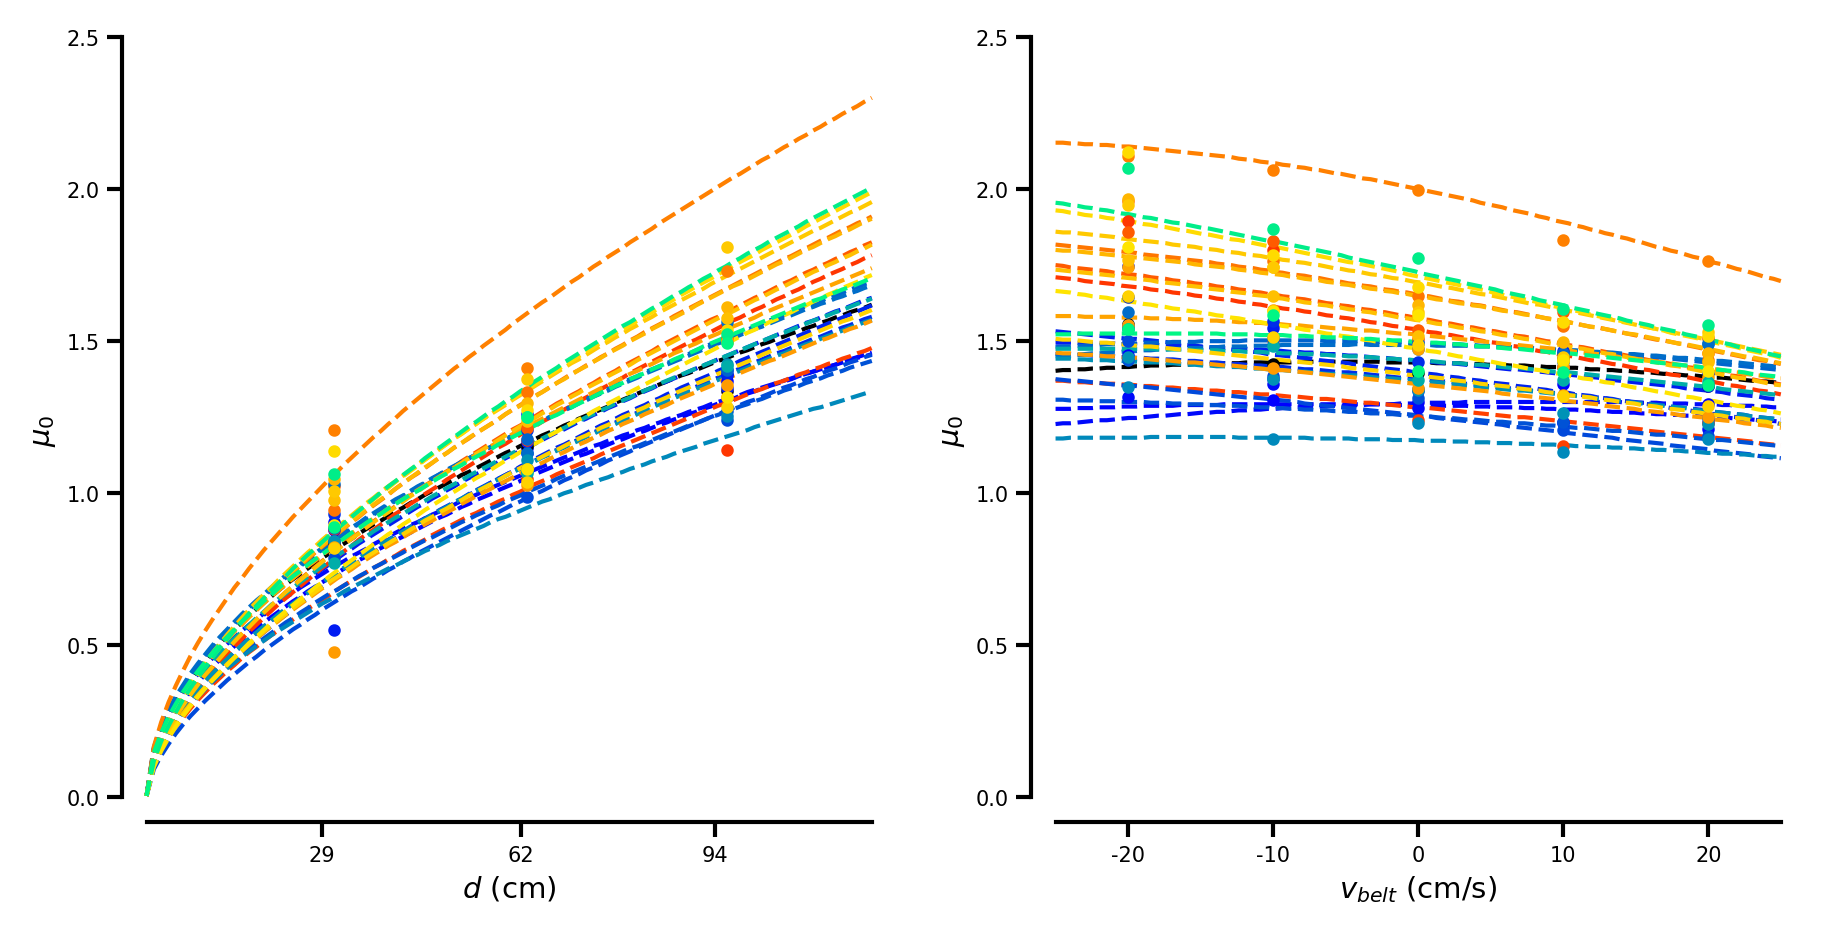

In [183]:

# Topt as a function of D
def Figure3E(ax=None, D_cst=.94, Vbelt_cst=0, EPSILON=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(0, 1.2, 100)

    for animal in animalList:
        ax.plot([.31, .63, .96], [mu_0[animal]['60'], mu_0[animal]['90'], mu_0[animal]['120']], 
                color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2, lw=0, zorder=10)

        ax.plot(D, [T_opt_n(d, Vbelt_cst, epsilon_0[animal], power_effort=power[animal], power_time=3) for d in D], 
                c=rat_markers[animal][0], ls='--')

    _ = r'$d$'
    ax.set_xlabel(f'{_} (cm)')
    ax.set_ylabel(r'$\mu_0$')
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.29, .62, .94])
    ax.set_xticklabels([29, 62, 94])
    space_axes(ax)

    # handles, labels = ax.get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # ax.legend(*zip(*unique), loc='upper left',# bbox_to_anchor=(0.01, 0.99), 
    #                         frameon=True, fontsize=5, markerscale=1, 
    #                         edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



# Topt as a function of Vbelt
def Figure3F(ax=None, D_cst=.94, Vbelt_cst=0, EPSILON=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(-.25, .25, 100)

    for animal in animalList:
        ax.plot([-.2, -.1, 0, .1, .2], [mu_0[animal]['rev20'], mu_0[animal]['rev10'], mu_0[animal]['2'], mu_0[animal]['10'], mu_0[animal]['20']], 
                color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2, lw=0, zorder=10)
        ax.plot(VBELT, [T_opt_n(D_cst, vbelt, epsilon_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT], 
                c=rat_markers[animal][0], ls='--')
    
    _ = r'$v_{belt}$'
    ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel(r'$\mu_0$')
    ax.set_xlim(-.25, 0.25)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    ax.set_xticklabels([-20, -10, 0, 10, 20])
    space_axes(ax)

    
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
Figure3E(ax=axs[0])
Figure3F(ax=axs[1])

No handles with labels found to put in legend.


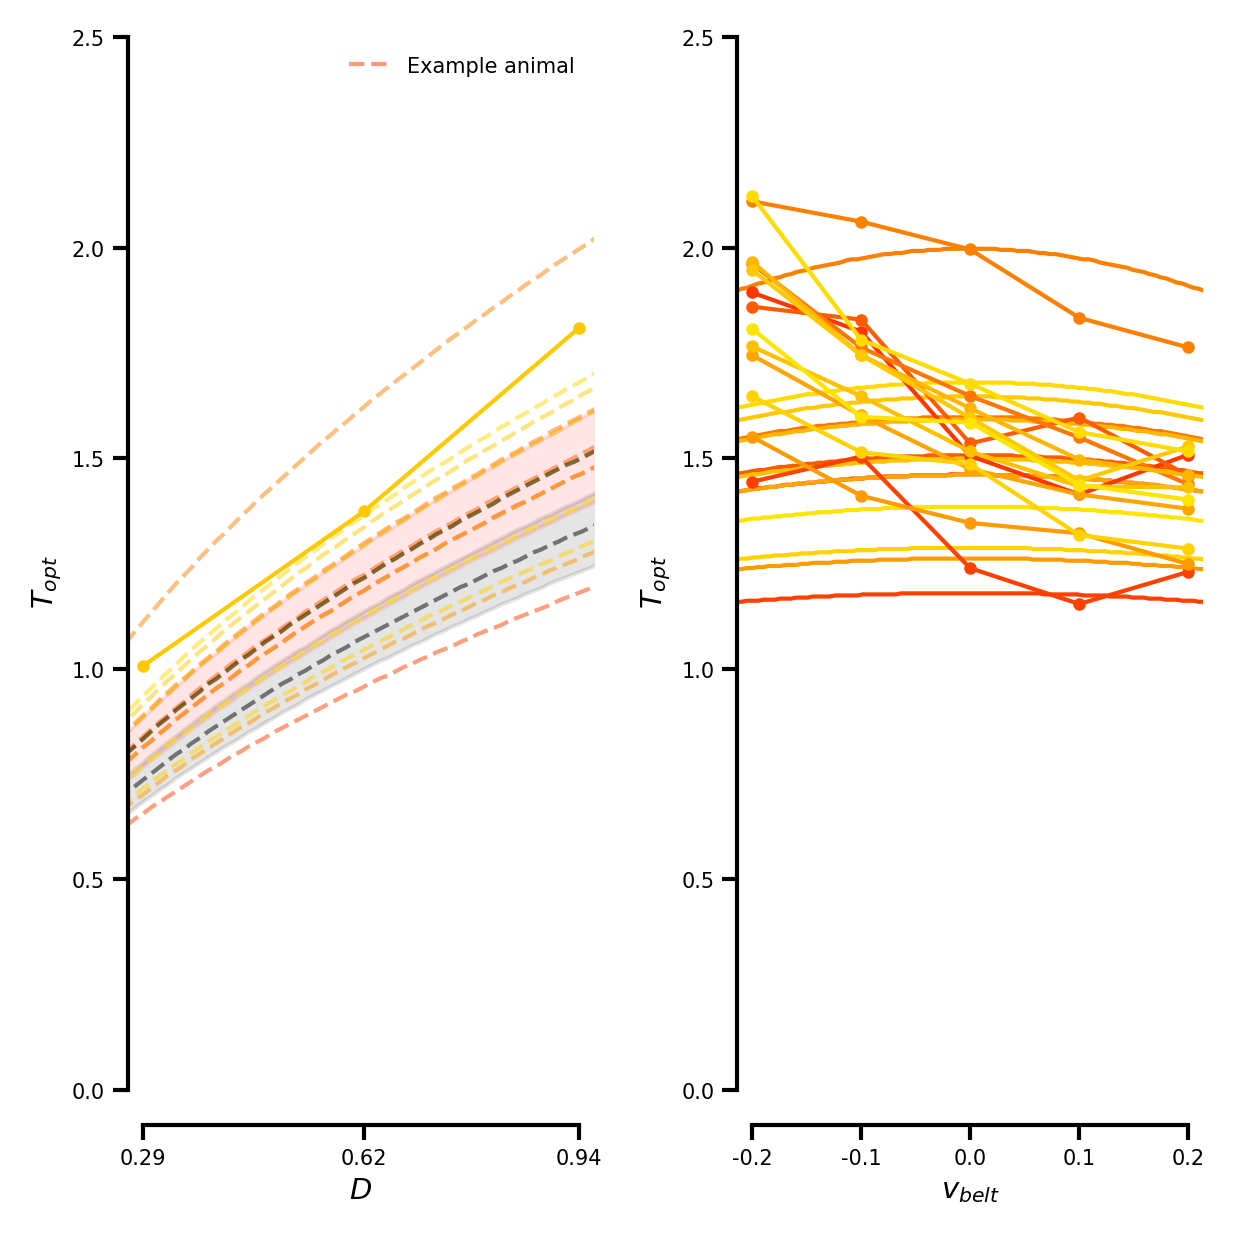

In [185]:
fig, axs = plt.subplots(1, 2, figsize=(4, 4))

def T_opt_n(D, vbelt, alpha, power_effort, power_time):
    np.seterr(divide='ignore', invalid='ignore')
    T = np.linspace(0.0, 2.5, 1000)
    vmax = (D - vbelt * T) / (T)
    cost = alpha * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt

# Topt as a function of D
def Figure3E(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(0, 1.2, 100)
 
    for animal in lesioned:
        # if brainstatus[animal] != 'normal':
            x = [medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal]]
            x = [.29, .62, .94]
            _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
            if animal == rat_example_lesion:
                ax.plot(x, [mu_0[animal]['60'], mu_0[animal]['90'], mu_0[animal]['120']], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2, lw=1, zorder=10)
            ax.plot(D, [T_opt_n(d, Vbelt_cst, epsilon_0[animal], power_effort=2, power_time=3) for d in D], 
                    label=f'Example animal', c=rat_markers[animal][0], ls='--', lw=1, alpha=.5)
            
    # plot median intact rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_intact_rat, power_effort=2, power_time=3) for d in D], 
                    label=f'Example animal', c='k', ls='--', lw=1, alpha=.5)
    ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_intact_rat - interquartile_intact_rat/2, power_effort=2, power_time=3) for d in D],
                        [T_opt_n(d, Vbelt_cst, median_intact_rat + interquartile_intact_rat/2, power_effort=2, power_time=3) for d in D],
                        label=f'Example animal', color='k', alpha=.1)

    # plot median lesion rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_lesion_rat, power_effort=2, power_time=3) for d in D],
                    label=f'Example animal', c='k', ls='--', lw=1, alpha=.5)
    ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_lesion_rat - interquartile_lesion_rat/2, power_effort=2, power_time=3) for d in D],
                        [T_opt_n(d, Vbelt_cst, median_lesion_rat + interquartile_lesion_rat/2, power_effort=2, power_time=3) for d in D],
                        label=f'Example animal', color='r', alpha=.1)
    
    ax.set_xlabel(r'$D$')
    ax.set_ylabel(r'$T_{opt}$')
    ax.set_xlim(.29, .94)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.29, .62, .94])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='best',# bbox_to_anchor=(0.01, 0.99), 
                            frameon=False, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


# Topt as a function of D
def Figure3F(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(-.25, .25, 100)
 
    for animal in lesioned:
        _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
        # if animal == rat_example_lesion:
        ax.plot([-.2, -.1, 0, .1, .2], 
                    [mu_0[animal]['rev20'], mu_0[animal]['rev10'], mu_0[animal]['2'], mu_0[animal]['10'], mu_0[animal]['20']], 
                    color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2, lw=1, zorder=10)
        ax.plot(VBELT, [T_opt_n(D_cst, vbelt, epsilon_0[animal], power_effort=2, power_time=3) for vbelt in VBELT], c=rat_markers[animal][0])

    # ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_intact_rat, power_effort=2, power_time=3) for vbelt in VBELT], c='k')
    # ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_intact_rat - interquartile_intact_rat/2, power_effort=2, power_time=3) for vbelt in VBELT],
    #                     [T_opt_n(D_cst, vbelt, median_intact_rat + interquartile_intact_rat/2, power_effort=2, power_time=3) for vbelt in VBELT],
    #                     color='k', alpha=.1)
    
    # ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_lesion_rat, power_effort=2, power_time=3) for vbelt in VBELT], c='k')
    # ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_lesion_rat - interquartile_lesion_rat/2, power_effort=2, power_time=3) for vbelt in VBELT],
    #                     [T_opt_n(D_cst, vbelt, median_lesion_rat + interquartile_lesion_rat/2, power_effort=2, power_time=3) for vbelt in VBELT],
    #                     color='r', alpha=.1)

    ax.set_xlabel(r'$v_{belt}$')
    ax.set_ylabel(r'$T_{opt}$')
    ax.set_xlim(-.2, 0.2)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='best',# bbox_to_anchor=(0.01, 0.99), 
                            frameon=False, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
    

Figure3E(ax=axs[0])
Figure3F(ax=axs[1])

No handles with labels found to put in legend.


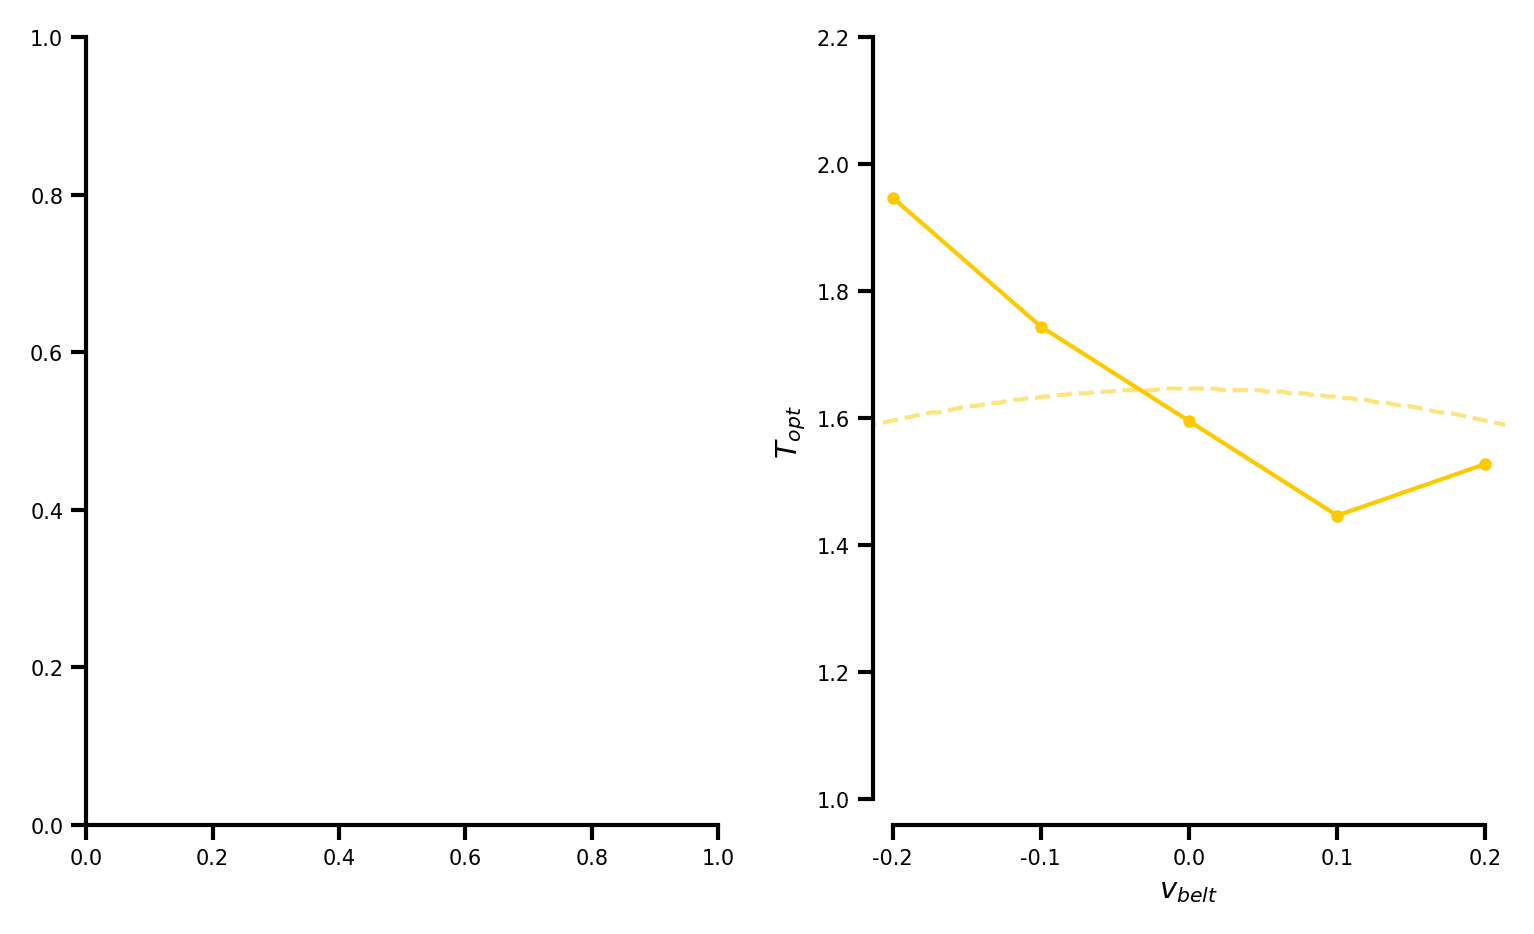

In [163]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3))

def T_opt_n(D, vbelt, alpha, power_effort, power_time):
    np.seterr(divide='ignore', invalid='ignore')
    T = np.linspace(0.0, 2.5, 1000)
    vmax = (D - vbelt * T) / (T)
    cost = alpha * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt

# Topt as a function of D
def Figure3E(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(0, 1.2, 100)
 
    for animal in animalList:
        if brainstatus[animal] != 'normal':
            x = [medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal]]
            x = [.29, .62, .94]
            _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
            if animal == rat_example_lesion:
                ax.plot(x, [mu_0[animal]['60'], mu_0[animal]['90'], mu_0[animal]['120']], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2, lw=1, zorder=10)
            ax.plot(D, [T_opt_n(d, Vbelt_cst, epsilon_0[animal], power_effort=2, power_time=3) for d in D], 
                    label=f'Example animal', c=rat_markers[animal][0], ls='--', lw=1, alpha=.5)
            
    # plot median intact rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_intact_rat, power_effort=2, power_time=3) for d in D], 
                    label=f'Example animal', c='k', ls='--', lw=1, alpha=.5)
    ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_intact_rat - interquartile_intact_rat/2, power_effort=2, power_time=3) for d in D],
                        [T_opt_n(d, Vbelt_cst, median_intact_rat + interquartile_intact_rat/2, power_effort=2, power_time=3) for d in D],
                        label=f'Example animal', color='k', alpha=.1)

    # plot median lesion rat
    ax.plot(D, [T_opt_n(d, Vbelt_cst, median_lesion_rat, power_effort=2, power_time=3) for d in D],
                    label=f'Example animal', c='k', ls='--', lw=1, alpha=.5)
    ax.fill_between(D, [T_opt_n(d, Vbelt_cst, median_lesion_rat - interquartile_lesion_rat/2, power_effort=2, power_time=3) for d in D],
                        [T_opt_n(d, Vbelt_cst, median_lesion_rat + interquartile_lesion_rat/2, power_effort=2, power_time=3) for d in D],
                        label=f'Example animal', color='r', alpha=.1)
    
    ax.set_xlabel(r'$D$')
    ax.set_ylabel(r'$T_{opt}$')
    ax.set_xlim(.29, .94)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.29, .62, .94])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='best',# bbox_to_anchor=(0.01, 0.99), 
                            frameon=False, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


# Topt as a function of D
def Figure3F(ax=None, D_cst=.94, Vbelt_cst=0, ALPHA=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(-.25, .25, 100)
 
    for animal in animalList:
        if brainstatus[animal] != 'normal':
            _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))
            if animal == rat_example_lesion:
                ax.plot([-.2, -.1, 0, .1, .2], 
                            [mu_0[animal]['rev20'], mu_0[animal]['rev10'], mu_0[animal]['2'], mu_0[animal]['10'], mu_0[animal]['20']], 
                            color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2, lw=1, zorder=10)
                ax.plot(VBELT, [T_opt_n(D_cst, vbelt, epsilon_0[animal], power_effort=2, power_time=3) for vbelt in VBELT],
                        c=rat_markers[animal][0], ls='--', lw=1, alpha=.5)

    # ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_intact_rat, power_effort=2, power_time=3) for vbelt in VBELT], c='k')
    # ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_intact_rat - interquartile_intact_rat/2, power_effort=2, power_time=3) for vbelt in VBELT],
    #                     [T_opt_n(D_cst, vbelt, median_intact_rat + interquartile_intact_rat/2, power_effort=2, power_time=3) for vbelt in VBELT],
    #                     color='k', alpha=.1)
    
    # ax.plot(VBELT, [T_opt_n(D_cst, vbelt, median_lesion_rat, power_effort=2, power_time=3) for vbelt in VBELT], c='k')
    # ax.fill_between(VBELT, [T_opt_n(D_cst, vbelt, median_lesion_rat - interquartile_lesion_rat/2, power_effort=2, power_time=3) for vbelt in VBELT],
    #                     [T_opt_n(D_cst, vbelt, median_lesion_rat + interquartile_lesion_rat/2, power_effort=2, power_time=3) for vbelt in VBELT],
    #                     color='r', alpha=.1)

    ax.set_xlabel(r'$v_{belt}$')
    ax.set_ylabel(r'$T_{opt}$')
    ax.set_xlim(-.2, 0.2)
    ax.set_ylim(1, 2.2)
    ax.set_xticks([-.2, -.1, 0, .1, .2])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='best',# bbox_to_anchor=(0.01, 0.99), 
                            frameon=False, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
    

# Figure3E(ax=axs[0])
Figure3F(ax=axs[1])

NameError: name 'intact' is not defined

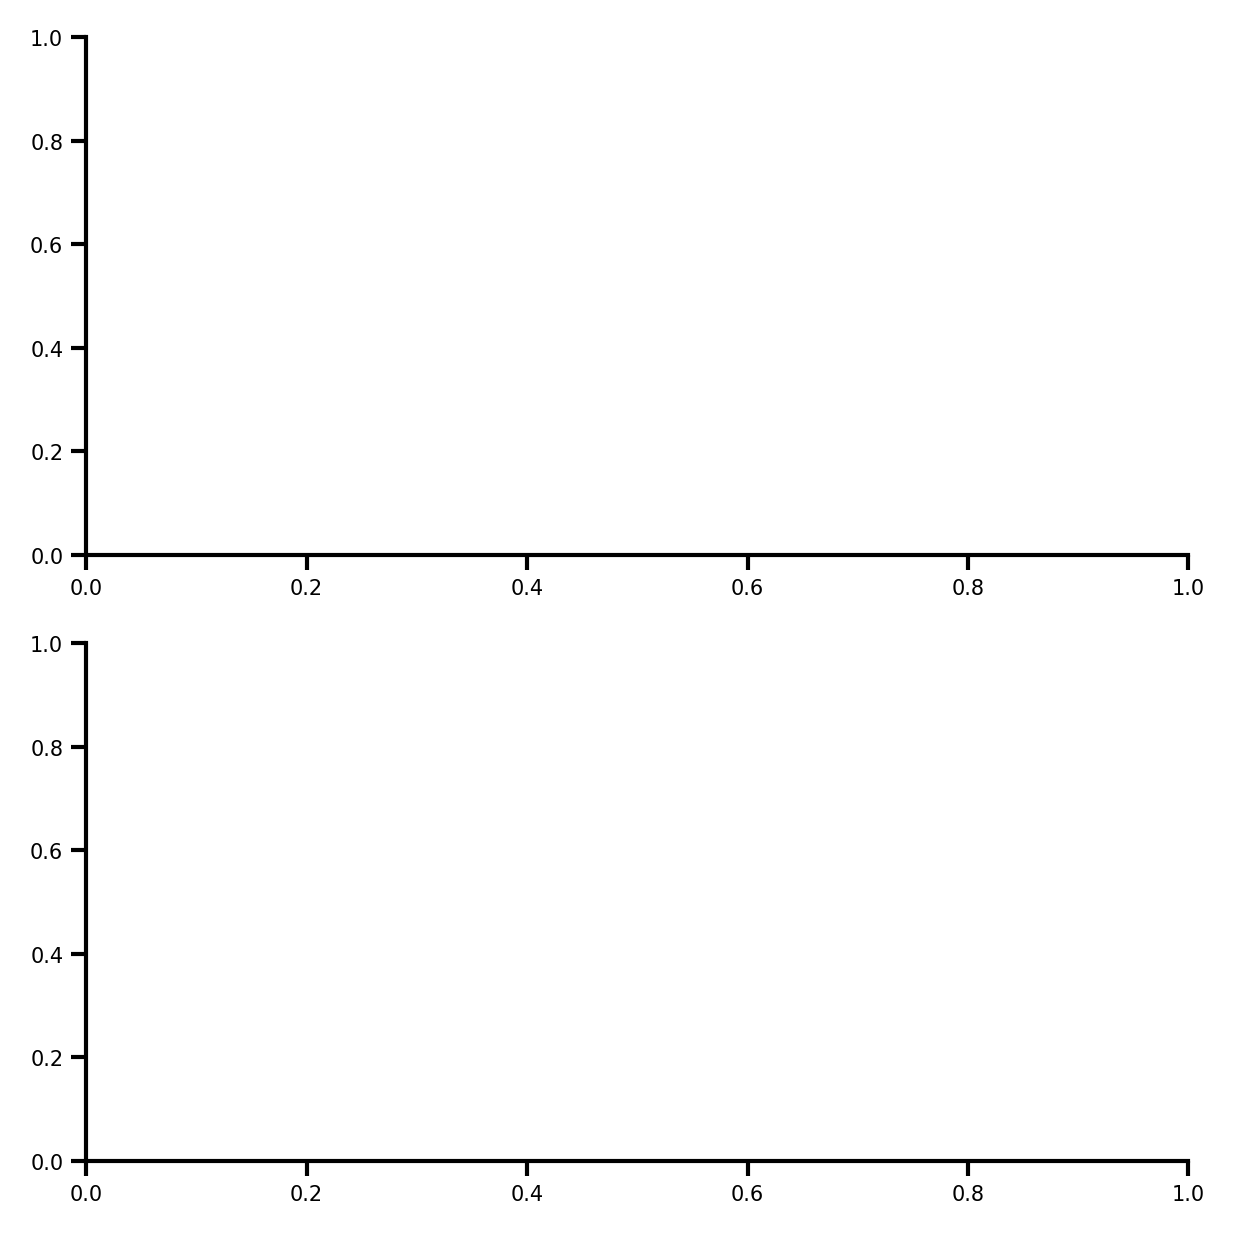

In [164]:
fig, axs = plt.subplots(2, 1, figsize=(4, 4))

def Figure5C(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/TESTintact_lesionFITS.p", "rb"))
    vars = alpha_0, alpha_t, gamma_0, gamma_t, gamma_R, mu_0, mu_t
    names = ('alpha_0', 'alpha_t', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t')
    labels = [r'$\alpha_0$', r"$\alpha_t$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$", r'$\mu_0$', r"$\mu_t$"]

    populationRi = {}
    conf_bottom = {}
    conf_top = {}
    indivRi = {}
    ICC_bootstrap = {}

    if os.path.exists("picklejar/ICC_resamples.p"):
        populationRi, indivRi, conf_bottom, conf_top, ICC_bootstrap = pickle.load(open("picklejar/ICC_resamples.p", "rb"))
    else:
        for i, (var, name) in enumerate(zip(vars, names)):
            populationRi[name], indivRi[name], (conf_bottom[name], conf_top[name], ICC_bootstrap[name]) = compute_ICC(var, animalList=intact, bootstrap=True)
        pickle.dump([populationRi, indivRi, conf_bottom, conf_top, ICC_bootstrap], open("picklejar/ICC_resamples.p", "wb"))

    # sort the vars by populationRi
    sorted_names = [x for _,x in sorted(zip(populationRi.values(), names), reverse=True)]
    sorted_labels = [x for _,x in sorted(zip(populationRi.values(), labels), reverse=True)]


    for i, name in enumerate(sorted_names):
        for animal in intact:
            ax.scatter(np.random.normal(i, 0.025), indivRi[name][animal], color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)

        # femalesRi = [indivRi[name][animal] for animal in intact if 'F' in animal]
        # malesRi = [indivRi[name][animal] for animal in intact if 'M' in animal]
        # print(f'{name} M vs F p = {exact_mc_perm_test(malesRi, femalesRi)}')
        # print(f'{name} M vs F p = {stats.mannwhitneyu(malesRi, femalesRi)}')

        line = 0.2/2
        ax.plot([i+.25-line, i+.25+line], [populationRi[name], populationRi[name]], color='k', lw=.75, zorder=1)
        ax.scatter(i+.25, populationRi[name], color='k', s=2.5, zorder=2)

        violin_parts = ax.violinplot(positions=[i+.25], 
                        dataset=[ICC_bootstrap[name]],
                        widths=.2, showextrema=False, 
                        quantiles=[0.05, 0.95])
        
        for vp in violin_parts['bodies']:
            vp.set_facecolor('lightgray')
            vp.set_edgecolor('lightgray')
            vp.set_linewidth(0)
            vp.set_alpha(1)
            vp.set_zorder(0)

        violin_parts['cquantiles'].set_facecolor('gray')
        violin_parts['cquantiles'].set_edgecolor('gray')
        violin_parts['cquantiles'].set_linewidth(.5)
        violin_parts['cquantiles'].set_alpha(1)
        violin_parts['cquantiles'].set_zorder(1)
        
        for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
            try:
                vp = violin_parts[partname]
                vp.set_edgecolor('gray')
                vp.set_linewidth(0)
                vp.set_alpha(0)
            except:
                pass

    ax.set_xlim(0, len(sorted_labels)-1)
    ax.set_xticks(range(len(sorted_labels)))
    ax.set_xticklabels(sorted_labels)
    ax.set_ylabel('ICC')
    ax.set_ylim(0, 1)
    # ax.set_yticklabels('')
    # ax.set_yticks([0, 0.5, 0.75, .9, 1])
    # ax.set_yticks([0.25, 0.625, 0.825, .95], minor=True)
    # ax.set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
    # ax.tick_params(which='minor', length=0)
    ax.set_yticks([0, 0.4, 0.6, 0.75, 1])
    # ax.set_yticks([0.2, 0.5, 0.675, 0.875], minor=True)
    # ax.set_yticklabels(["Poor", "Fair", "Good", "Excellent"], minor=True)
    # ax.tick_params(which='minor', length=0)
    space_axes(ax, x_ratio_right=.1)


def Figure5D(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/TESTintact_lesionFITS.p", "rb"))
    vars = alpha_0, alpha_t, gamma_0, gamma_t, gamma_R, mu_0, mu_t
    names = ('alpha_0', 'alpha_t', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t')
    labels = [r'$\alpha_0$', r"$\alpha_t$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_R$", r'$\mu_0$', r"$\mu_t$"]

    populationRi = {}
    conf_bottom = {}
    conf_top = {}
    indivRi = {}
    ICC_bootstrap = {}

    if os.path.exists("picklejar/ICC_resamples.p"):
        populationRi, indivRi, conf_bottom, conf_top, ICC_bootstrap = pickle.load(open("picklejar/ICC_resamples.p", "rb"))
    else:
        for i, (var, name) in enumerate(zip(vars, names)):
            populationRi[name], indivRi[name], (conf_bottom[name], conf_top[name], ICC_bootstrap[name]) = compute_ICC(var, animalList=intact, bootstrap=True)
        pickle.dump([populationRi, indivRi, conf_bottom, conf_top, ICC_bootstrap], open("picklejar/ICC_resamples.p", "wb"))

    for i, animal in enumerate(intact):

        ax.scatter([i] * len([indivRi[name][animal] for name in names]),
                        [indivRi[name][animal] for name in names],
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], s=5)
                        
        lower = np.percentile([indivRi[name][animal] for name in names], 5)
        upper = np.percentile([indivRi[name][animal] for name in names], 95)

        ax.errorbar(i, np.median([indivRi[name][animal] for name in names]), 
                        yerr=[[np.median([indivRi[name][animal] for name in names]) - lower], 
                                [upper - np.median([indivRi[name][animal] for name in names])]],
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        capsize=5, capthick=1, elinewidth=1)

    ax.set_xlim(0, len(intact)-1)
    ax.set_xticks(range(len(intact)))
    ax.set_xticklabels(intact, rotation=90)
    ax.set_ylabel('Overall ICC')
    ax.set_ylim(0, 1)
    # ax.set_yticklabels('')
    # ax.set_yticks([0, 0.5, 0.75, .9, 1])
    # ax.set_yticks([0.25, 0.625, 0.825, .95], minor=True)
    # ax.set_yticklabels(["Poor", "Moderate", "Good", "Excellent"], minor=True)
    # ax.tick_params(which='minor', length=0)
    ax.set_yticks([0, 0.4, 0.6, 0.75, 1])   
    # ax.set_yticks([0.2, 0.5, 0.675, 0.875], minor=True)
    # ax.set_yticklabels(["Poor", "Fair", "Good", "Excellent"], minor=True)
    # ax.tick_params(which='minor', length=0)
    space_axes(ax)


Figure5C(axs[0])
Figure5D(axs[1])

In [ ]:
fig = plt.figure(figsize=(cm2inch(18), cm2inch(12)), constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(5, 1, wspace=.5, hspace=.5, height_ratios=[3, 1, 15, 1, 3])

row1 = gs0[0].subgridspec(1, 4)
coordinates = plt.subplot(row1[0, 0])
lesion_example = plt.subplot(row1[0, 1])
lesion_example = plt.subplot(row1[0, 2])
lesion_example = plt.subplot(row1[0, 3])

row2 = gs0[2].subgridspec(3, 4, width_ratios=[1, 1, 1, 3])
comparison_epsilon_0 = plt.subplot(row2[0, 0])
comparison_epsilon_t = plt.subplot(row2[0, 1])
comparison_epsilon_R = plt.subplot(row2[0, 2])
spare = plt.subplot(row2[0, 3])

comparison_alpha_0 = plt.subplot(row2[1, 0])
comparison_alpha_t = plt.subplot(row2[1, 1])
comparison_alpha_R = plt.subplot(row2[1, 2])
spare = plt.subplot(row2[1, 3])

comparison_gamma_0 = plt.subplot(row2[2, 0])
comparison_gamma_t = plt.subplot(row2[2, 1])
comparison_gamma_R = plt.subplot(row2[2, 2])
spare = plt.subplot(row2[2, 3])


row3 = gs0[4].subgridspec(1, 3, width_ratios=[2, 2, 4])
PCA1 = plt.subplot(row3[0, 0])
PCA2 = plt.subplot(row3[0, 1])
Ri = plt.subplot(row3[0, 2])

figuresLabels={"A":[0.00, 1.00], "B":[0.25, 1.00], "C":[0.50, 1.00], "D":[0.75, 1.00],
               "E":[0.00, 0.65], "F":[0.22, 0.65], "G":[0.415, 0.65], "H":[0.61, 0.65], "I":[0.805, 0.65],
               "J":[0.00, 0.31], "K":[0.22, 0.31], "L":[0.415, 0.31], "M":[0.61, 0.31], "N":[0.805, 0.31]}

# for label,coordinates in sorted(figuresLabels.items()):
#     fig.text(coordinates[0], coordinates[1],
#              label, figure=fig, 
#              weight='bold', fontsize=7, ha='left', va='bottom')
    


Figure6_A(ax = comparison_epsilon_0)
Figure6_B(ax = comparison_epsilon_t)
Figure6_C(ax = comparison_epsilon_R)

Figure6_D(ax = comparison_alpha_0)
Figure6_E(ax = comparison_alpha_t)
Figure6_F(ax = comparison_alpha_R)

Figure6_G(ax = comparison_gamma_0)
Figure6_H(ax = comparison_gamma_t)
Figure6_I(ax = comparison_gamma_R)



plt.savefig("/home/david/Desktop/code/Figure_6.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

In [ ]:
conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']

alpha_0, alpha_t, alpha_R, gamma_0, gamma_t, gamma_R, mu_0, mu_t, mu_R, sigma_0, sigma_t, sigma_R = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

_alpha_0 = {animal: np.median([alpha_0[animal][cond] for cond in conds]) for animal in animalList}
_alpha_t = {animal: np.median([alpha_t[animal][cond] for cond in conds]) for animal in animalList}
_alpha_R = {animal: np.median([alpha_R[animal][cond] for cond in conds]) for animal in animalList}
_gamma_0 = {animal: np.median([gamma_0[animal][cond] for cond in conds]) for animal in animalList}
_gamma_t = {animal: np.median([gamma_t[animal][cond] for cond in conds]) for animal in animalList}
_gamma_R = {animal: np.median([gamma_R[animal][cond] for cond in conds]) for animal in animalList}
_mu_0 = {animal: np.median([mu_0[animal][cond] for cond in conds]) for animal in animalList}
_mu_t = {animal: np.median([mu_t[animal][cond] for cond in conds]) for animal in animalList}
_mu_R = {animal: np.median([mu_R[animal][cond] for cond in conds]) for animal in animalList}
_sigma_0 = {animal: np.median([sigma_0[animal][cond] for cond in conds]) for animal in animalList}
_sigma_t = {animal: np.median([sigma_t[animal][cond] for cond in conds]) for animal in animalList}
_sigma_R = {animal: np.median([sigma_R[animal][cond] for cond in conds]) for animal in animalList}

vars = [epsilon_0, epsilon_t, epsilon_R, _alpha_0, _alpha_t, _alpha_R, _gamma_0, _gamma_t, _gamma_R, _mu_0, _mu_t, _mu_R, _sigma_0, _sigma_t, _sigma_R]
names = ['epsilon_0', 'epsilon_t', 'epsilon_R', 'alpha_0', 'alpha_t', 'alpha_R', 'gamma_0', 'gamma_t', 'gamma_R', 'mu_0', 'mu_t', 'mu_R', 'sigma_0', 'sigma_t', 'sigma_R']

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in animalList:
        if animal in lesion_area.keys():
            ax.scatter(lesion_area[animal], var[animal], label=animal, color=rat_markers[animal][0])
            x.append(lesion_area[animal])
            y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion size')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')

In [ ]:

fig, axs = plt.subplots(5, 3, figsize=(6, 10))
for ax, var, name in zip(axs.flatten(), vars, names):
    x, y = [], []
    for animal in animalList:
        if animal in lesion_pos.keys():
            ax.scatter(lesion_pos[animal], var[animal], label=animal+brainstatus[animal])
            x.append(lesion_pos[animal])
            y.append(var[animal])

    pearson = stats.pearsonr(x, y)
    print(name+f' corr: {pearson[0]:.2f}, p: {pearson[1]:.4f}')
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(np.linspace(np.min(x), np.max(x), 100), gradient * np.linspace(np.min(x), np.max(x), 100) + intercept, color='g' if p_value < 0.05 else 'r')

    ax.set_xlabel('Lesion position')
    ax.set_ylabel(name)
    ax.set_title(f'p={p_value:.4f}, r={r_value:.2f}')

axs[1, 2].legend()